# Supplementary Information:

> **"Background-dependent effects of selection on subclonal heterogeneity"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 2 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figures 2, S3, S4 and S7 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
%matplotlib inline

import json,matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import numpy as np
import pandas as pd # (*) Pandas for data manipulation

# load internal dependencies
import colors,plot,gmm,utils,config

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

In [2]:
ids = pd.read_csv(dir_data+'seq/sample_ids_merged_dup.csv')

ids.loc[ids.clone.isnull(),'type'] = 'population'
ids.loc[(ids.clone.notnull()) & (ids.time==0),'type'] = 'ancestral clone'
ids.loc[(ids.clone.notnull()) & (ids.time==32),'type'] = 'evolved clone'

for seq_type, seq_id in ids.groupby('type'):
    print '{0} sequencing coverage\nBottom quartile: {1:.2f}x, Top quartile: {2:.2f}x, Min: {3:.2f}x, Max: {4:.2f}x, Median: {5:.2f}x\n'\
    .format(seq_type.capitalize(),
            seq_id['coverage'].quantile(.25), \
            seq_id['coverage'].quantile(.75), \
            seq_id['coverage'].min(), \
            seq_id['coverage'].max(), \
            seq_id['coverage'].median())

Ancestral clone sequencing coverage
Bottom quartile: 15.45x, Top quartile: 26.13x, Min: 9.06x, Max: 36.60x, Median: 23.37x

Evolved clone sequencing coverage
Bottom quartile: 28.48x, Top quartile: 31.96x, Min: 26.06x, Max: 36.01x, Median: 30.38x

Population sequencing coverage
Bottom quartile: 84.10x, Top quartile: 103.98x, Min: 24.66x, Max: 150.10x, Median: 94.81x



## Data import

Top panels - Import subclonal frequency

In [3]:
# load data
seq_st_df = utils.load_data(dir_data+'seq/subclonality/seq_subclonality.pickle')

# compute cumulative haplotype frequencies for major subclones
seq_st_df['clonal'] = seq_st_df.apply(lambda x: 
                                      x[['subclone A','subclone B','subclone C','subclone D']].fillna(0).sum(), 
                                      axis=1)
# calculate the remaining bulk fraction
seq_st_df['bulk'] = 1.0 - seq_st_df['clonal']

seq_st_df.head()

,background,cross,cross_rep,selection,selection_rep,subclone A,subclone B,subclone C,subclone D,time,population,sample,clonal,bulk
0,WAxNA,F12,2,RM,2,0.0200,NaN,NaN,NaN,2,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T2,0.0200,0.9800
1,WAxNA,F12,2,RM,2,0.0202,NaN,NaN,NaN,4,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T4,0.0202,0.9798
2,WAxNA,F12,2,RM,2,0.0705,NaN,NaN,NaN,8,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T8,0.0705,0.9295
3,WAxNA,F12,2,RM,2,0.1098,NaN,NaN,NaN,16,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T16,0.1098,0.8902
4,WAxNA,F12,2,RM,2,0.1097,NaN,NaN,NaN,32,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T32,0.1097,0.8903


Middle panels - Import mutation counts

In [4]:
# load data
seq_dn_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

seq_dn_df.loc[seq_dn_df['alt'].apply(lambda x: len(x[0])) == 1, 'variant_type'] = 'snp'
seq_dn_df.loc[(seq_dn_df['ref'].apply(len) > 1) | \
              (seq_dn_df['alt'].apply(lambda x: len(x[0])) > 1), 'variant_type'] = 'indel'

seq_dn_df.loc[seq_dn_df.biotype.isnull(), 'biotype'] = 'non-coding'

print seq_dn_df.shape
seq_dn_df.head()

(572, 80)


,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chrom,...,selection_rep,time,clone,population,coverage,substitution,assignment,mutation_type,consequence_short,variant_type
0,1,0.1,[A],2.0,NaN,NaN,non-coding,1.093,NaN,7,...,1,16,,NA_HU_1,57.370612,G>A,bulk,passenger,NaN,snp
1,0,0.1,[A],2.0,A,K/M,protein_coding,-0.027,341,7,...,1,16,,NA_HU_1,57.370612,T>A,bulk,driver,non-synonymous,snp
2,0,0.1,[A],2.0,A,R/I,protein_coding,-1.198,101,7,...,1,16,,NA_HU_1,57.370612,C>A,bulk,driver,non-synonymous,snp
3,1,0.1,[T],2.0,NaN,NaN,non-coding,0.395,NaN,12,...,1,16,,NA_HU_1,57.370612,C>T,bulk,passenger,NaN,snp
4,1,0.1,[A],2.0,A,G,protein_coding,0.956,861,14,...,1,16,,NA_HU_1,57.370612,C>A,bulk,passenger,synonymous,snp


The tally of SNPs and indels across whole-population genome sequences is:

In [5]:
seq_dn_df[(seq_dn_df.clone!='')].groupby(['selection','population','time','variant_type']).size()

selection  population        time  variant_type
HU         WAxNA_F12_1_HU_1  32    snp             11
           WAxNA_F12_1_HU_2  32    snp             10
           WAxNA_F12_1_HU_3  32    snp             17
           WAxNA_F12_2_HU_1  32    snp              8
           WAxNA_F12_2_HU_2  32    snp             17
           WAxNA_F12_2_HU_3  32    indel            1
                                   snp             19
RM         WAxNA_F12_1_RM_1  32    indel            1
                                   snp             10
           WAxNA_F12_1_RM_2  32    snp             14
           WAxNA_F12_1_RM_3  32    snp             15
           WAxNA_F12_2_RM_1  32    snp              9
           WAxNA_F12_2_RM_2  32    snp              6
           WAxNA_F12_2_RM_3  32    snp              2
YPD        WAxNA_F12_1_YPD   0     indel            2
                                   snp             38
           WAxNA_F12_2_YPD   0     indel            7
                                  

In [6]:
seq_dn_df.loc[(seq_dn_df.clone!='')&(seq_dn_df.time==32)&(seq_dn_df.variant_type=='indel'),'gene']

226    non-coding
434          CRH1
Name: gene, dtype: object

In [7]:
seq_dn_df[(seq_dn_df.time==0) & (seq_dn_df.clone!='') & (seq_dn_df.ploidy=='haploid')].groupby(['selection','mutation_type','variant_type']).size()

selection  mutation_type  variant_type
YPD        passenger      indel            9
                          snp             82
dtype: int64

In [8]:
seq_dn_df[(seq_dn_df.time==32) & (seq_dn_df.clone!='')].groupby(['selection','mutation_type','variant_type']).size()

selection  mutation_type  variant_type
HU         driver         snp             22
           passenger      indel            1
                          snp             60
RM         driver         snp             13
           passenger      indel            1
                          snp             43
dtype: int64

Bottom panels - Import phenotype evolution

In [9]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_abs.pickle')

pheno_df['doubling_time'] = np.log2(1/(pheno_df['growth_rate']))

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.group == 'ancestral')|\
                    (pheno_df.group == 'evolved')]

groups_1 = pheno_df.groupby(['group','cross','cross_rep','selection','selection_rep'])
pheno_df = pheno_df[pheno_df.selection_rep != '']

for (ii,((group,cross,cross_rep,selection,selection_rep),g1)) in enumerate(groups_1):
    
    if group=='evolved':
        df = groups_1.get_group(('ancestral',cross,cross_rep,selection,''))        
        df.loc[:,'selection_rep'] = df.selection_rep.replace([''],[selection_rep])
        df.loc[:,'population'] = df['background']+'_'+df['cross']+'_'+df['cross_rep'].apply(str)+'_'+df['selection']+'_'+df['selection_rep'].apply(str)

        pheno_df = pheno_df.append(df)
        
pheno_df = pheno_df.reset_index(drop=True)

# # set reference as mean phenotype of the ancestral hybrid
# def norm(df):
#     df['doubling_time'] = df['doubling_time'] - df[df.group=='ancestral'].growth_rate.mean()
#     return df

# pheno_df = pheno_df.groupby(['selection','environment','population'], as_index=False).apply(norm)
        
# # filter out measurement replicates with >5% measurement error
# pheno_df['pct'] = pheno_df.groupby(['selection','environment','group',\
#                                     'population','isolate','genotype_long'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# pheno_df = pheno_df[abs(pheno_df['pct'])<0.05]

pheno_df.head()  # show dataframe header to stdout

/Users/ivg/.virtualenvs/science-advances-2016/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,selection,environment,run,index,plate,row,column,group,population,background,...,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,growth_rate,lag,yield,doubling_time
0,HU,HU,1,2,0,0,2,evolved,WAxNA_F12_1_HU_3,WAxNA,...,,+/+,,,MATa/α,,0.065577,0.882543,1.861618e+06,3.930664
1,HU,HU,1,3,0,0,3,evolved,WAxNA_F12_2_HU_3,WAxNA,...,,+/+,,,MATa/α,,0.058038,0.629816,1.198933e+06,4.106870
2,HU,HU,1,6,0,0,6,evolved,WAxNA_F12_1_HU_3,WAxNA,...,,+/+,,,MATa/α,,0.105026,0.977159,2.079955e+06,3.251181
3,HU,HU,1,7,0,0,7,evolved,WAxNA_F12_2_HU_3,WAxNA,...,,+/+,,,MATa/α,,0.085085,1.000542,1.537418e+06,3.554953
4,HU,HU,1,10,0,0,10,evolved,WAxNA_F12_1_HU_3,WAxNA,...,,+/+,,,MATa/α,,0.108511,0.884375,1.686254e+06,3.204089


In [21]:
# pheno_df

# df['growth_rate'] = 1/(2**df['doubling_time'])

pheno_df['doubling_time']# = np.log2(1/(pheno_df['growth_rate']))

0         3.930664
1         4.106870
2         3.251181
3         3.554953
4         3.204089
5         4.161344
6         3.850686
7         4.413772
8         3.239353
9         3.490118
10        4.390911
11        4.030587
12        4.267671
13        3.606849
14        3.497022
15        3.377872
16        3.817926
17        4.569340
18        4.033442
19        4.079863
20        4.379431
21        3.402115
22        3.779478
23        3.269392
24        3.923519
25        3.292311
26        4.325999
27        3.232219
28        4.386262
29        3.969786
            ...   
119522    2.013429
119523    1.915791
119524    1.915071
119525    1.840481
119526    2.060350
119527    1.824816
119528    2.018776
119529    2.101950
119530    2.187383
119531    2.284388
119532    2.259880
119533    2.353498
119534    2.248945
119535    2.025302
119536    1.989210
119537    1.948651
119538    1.978045
119539    1.837264
119540    1.975497
119541    2.169086
119542    2.215404
119543    2.

In [22]:

pheno_df['growth_rate']

0         0.065577
1         0.058038
2         0.105026
3         0.085085
4         0.108511
5         0.055887
6         0.069315
7         0.046916
8         0.105891
9         0.088996
10        0.047666
11        0.061189
12        0.051916
13        0.082079
14        0.088571
15        0.096196
16        0.070907
17        0.042120
18        0.061068
19        0.059134
20        0.048046
21        0.094593
22        0.072822
23        0.103709
24        0.065903
25        0.102074
26        0.049859
27        0.106416
28        0.047819
29        0.063823
            ...   
119522    0.247684
119523    0.265027
119524    0.265159
119525    0.279229
119526    0.239758
119527    0.282277
119528    0.246768
119529    0.232943
119530    0.219549
119531    0.205272
119532    0.208789
119533    0.195671
119534    0.210378
119535    0.245654
119536    0.251877
119537    0.259058
119538    0.253834
119539    0.279852
119540    0.254282
119541    0.222351
119542    0.215326
119543    0.

## Figure 2 - Subclonal heterogeneity

HU WAxNA_F12_1_HU_2 ancestral
3.61130604643
HU WAxNA_F12_1_HU_2 evolved
3.37594831287
HU WAxNA_F12_1_HU_3 ancestral
3.61130604643
HU WAxNA_F12_1_HU_3 evolved
3.25292355344
HU WAxNA_F12_2_HU_3 ancestral
3.73259311458
HU WAxNA_F12_2_HU_3 evolved
3.11252730883


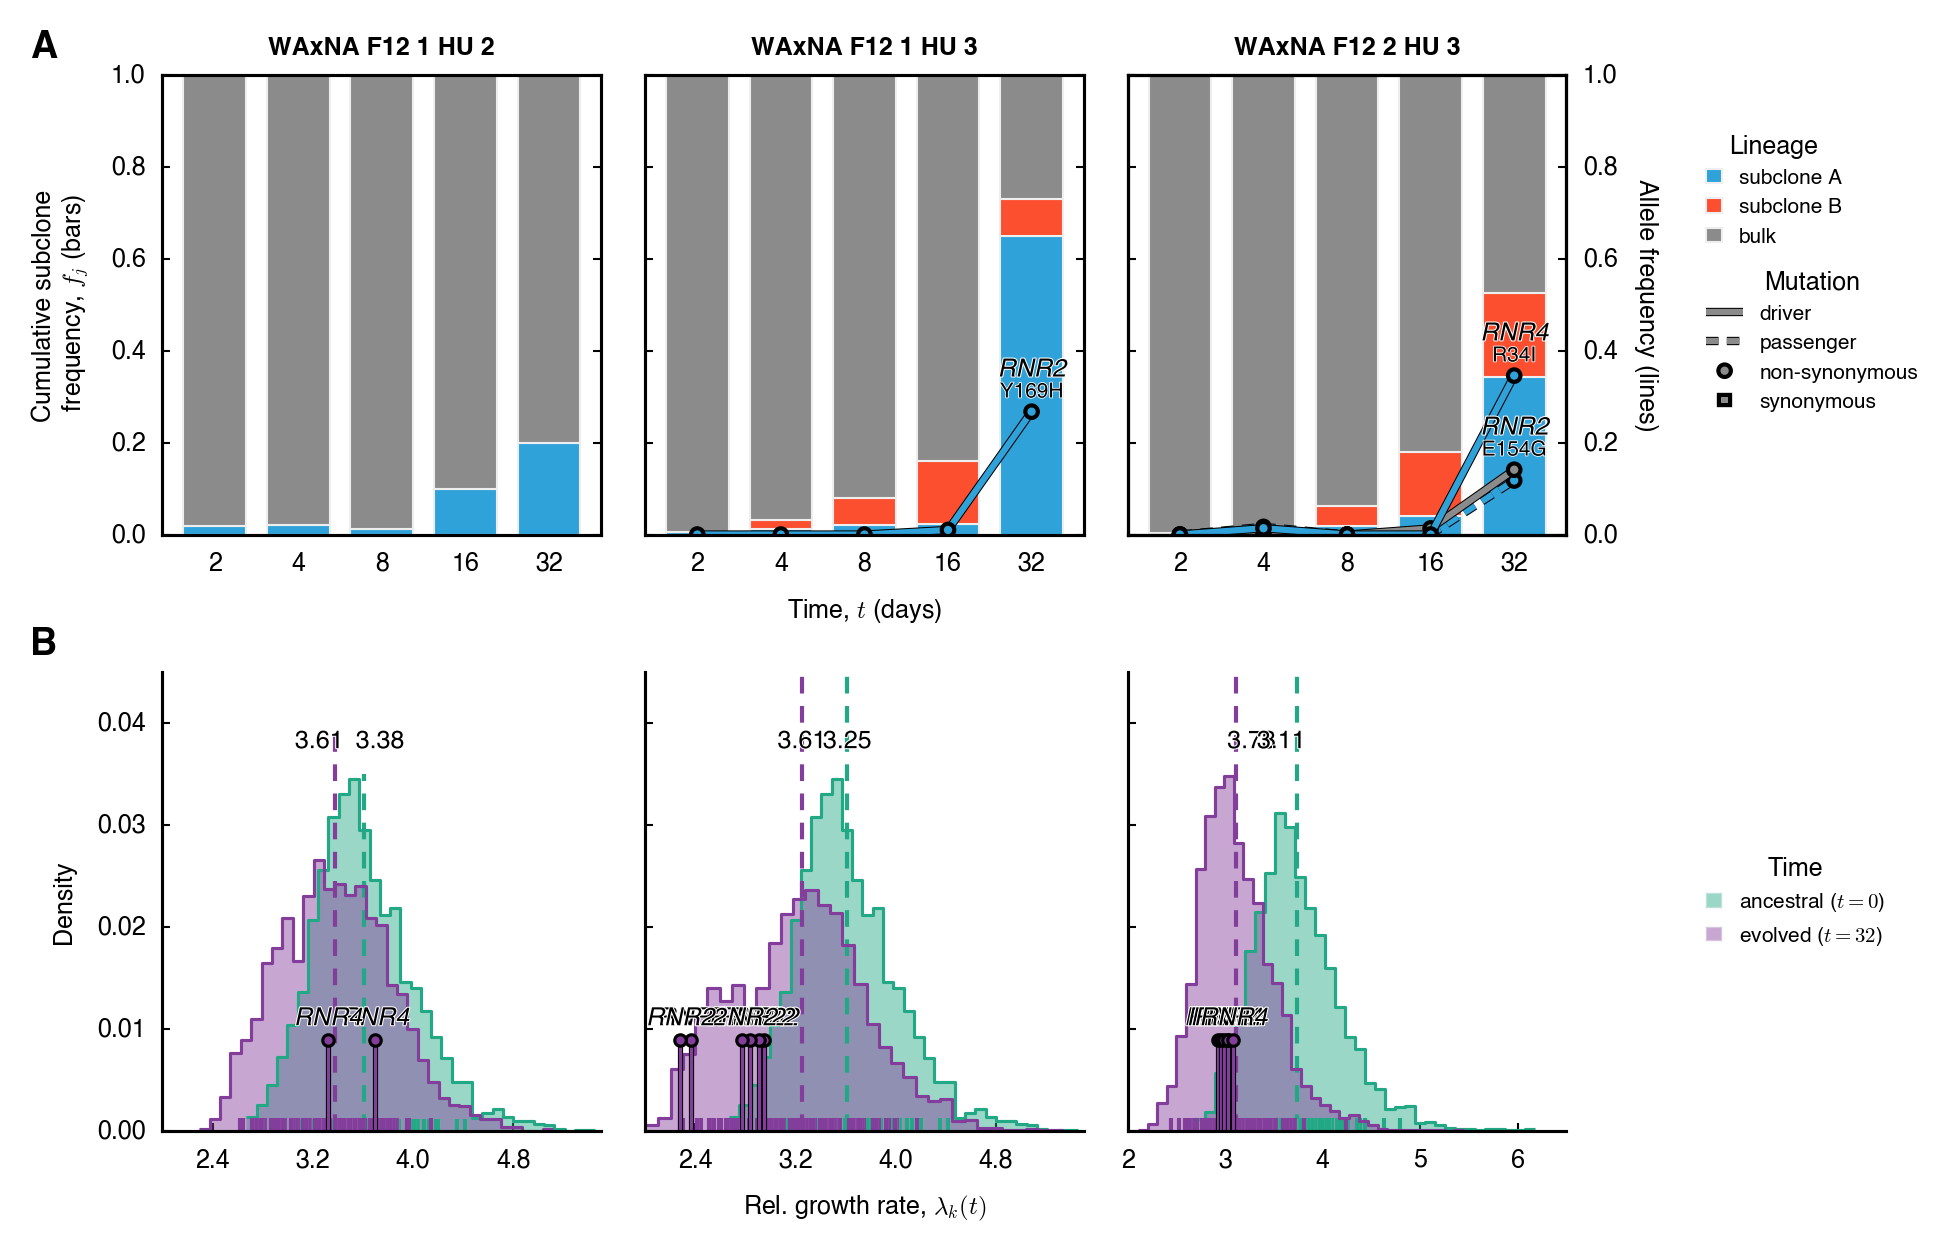

RM WAxNA_F12_1_RM_3 ancestral
4.47568124975
RM WAxNA_F12_1_RM_3 evolved
2.12380817761
4.12620617274
RM WAxNA_F12_1_RM_4 ancestral
4.47568124975
RM WAxNA_F12_1_RM_4 evolved
2.34488335978
3.97235023881
RM WAxNA_F12_2_RM_2 ancestral
4.59861238793
RM WAxNA_F12_2_RM_2 evolved
4.25391313089
2.31057821489
6.77628507736


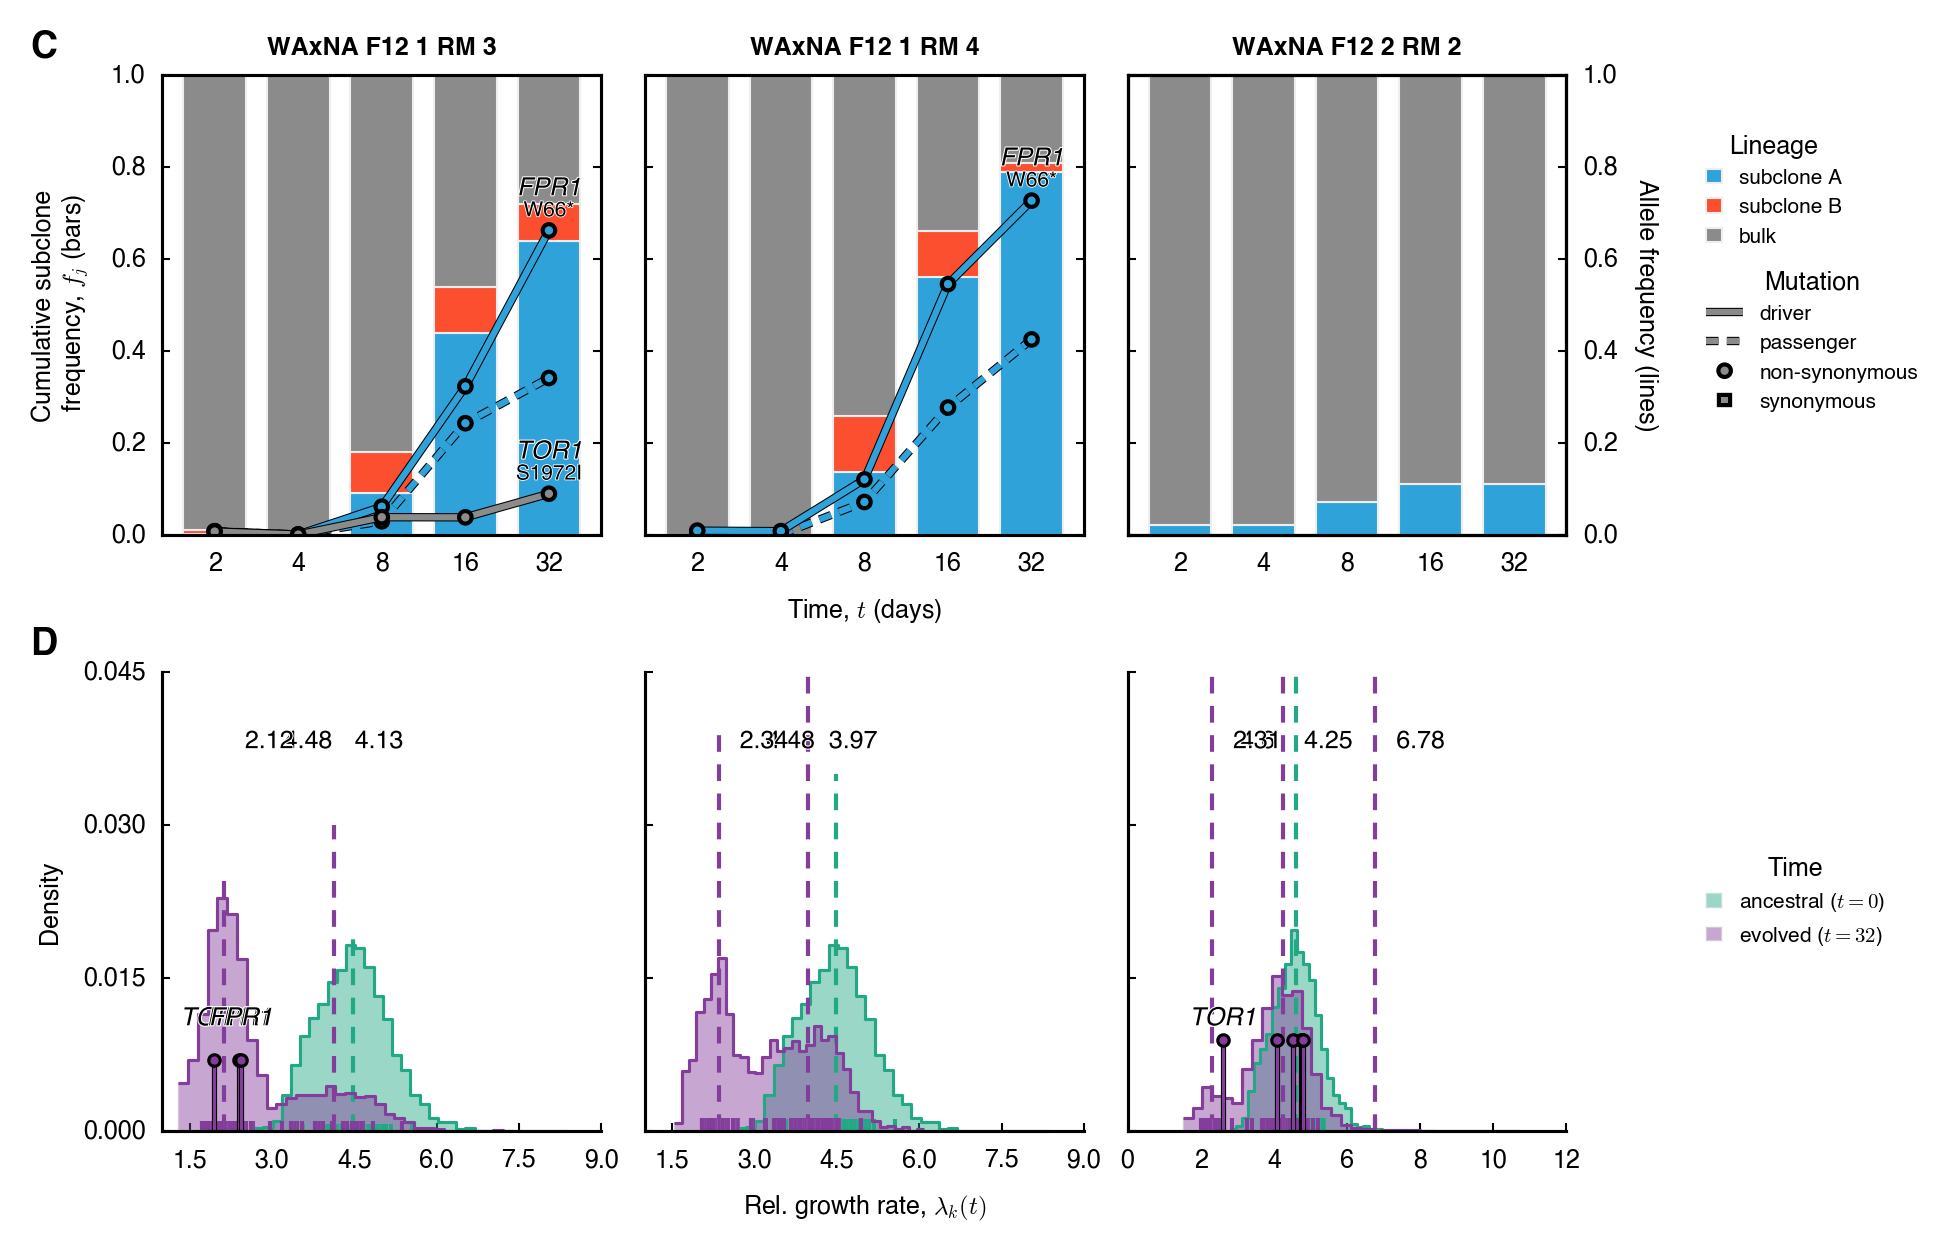

In [24]:
param = 'doubling_time'

panels = {
    'HU': {
        'WAxNA_F12_1_HU_2':0,
        'WAxNA_F12_1_HU_3':1,
        'WAxNA_F12_2_HU_3':2
    },
    'RM': {
        'WAxNA_F12_1_RM_3':0,
        'WAxNA_F12_1_RM_4':1,
        'WAxNA_F12_2_RM_2':2
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)]
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))&\
                      (seq_dn_df.clone=='')]
groups_ph = pheno_df[pheno_df.population.isin(populations)]

groups_st = groups_st.groupby('selection')
groups_dn = groups_dn.groupby('selection')
groups_ph = groups_ph.groupby(['selection','environment'])

for (ii, env) in enumerate(['HU','RM']):
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), sharey='row')
    
    fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.3,wspace=0.1)
    
    # set scales
    for ax in axes[0]:
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 1)
#     for ax in axes[1]:
#         if env=='HU':
#             ax.set_xlim(-0.3, 0.5)
#             ax.set_ylim(0, 0.15)
#         elif env=='RM':
#             ax.set_xlim(-0.5, 1.9)
#             ax.set_ylim(0, 0.12)

    ### top panels ###
    # de novo mutations #
    for (jj, (population, gdn)) in enumerate(groups_dn.get_group(env).groupby('population')):
        
        # retrieve axes
        ax1 = axes[0][panels[env][population]]
        
        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]
            
            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            
            ax1.plot(gdx.index.values, gdx.frequency.values,
                     color=config.lineages[assignment]['fill'], 
                     **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                             config.consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax1.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                             textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax1.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                             xy=(index,gdx.frequency[index]), fontsize=5,
                             textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)
    
    # subclonal frequency #
    for (jj, (population,gst)) in enumerate(groups_st.get_group(env).groupby('population')):

        # retrieve axes
        ax2 = axes[0][panels[env][population]]

        # 
        ax2.set_title(population.replace('_',' '), fontsize=6, weight='bold')
        # 
        gst.set_index('time', inplace=True)
        colors=[config.lineages[x]['fill'] for x in ['subclone A','subclone B','bulk']]
        gst[['subclone A','subclone B','bulk']].plot(ax=ax2, kind='bar', legend=False, 
                                                     stacked=True, rot=0, width=0.75, position=0.5,
                                                     color=colors)
        
        # rotate the x-axis ticks
        ax2.set_xlabel('', rotation=0)

    ### bottom panels ###
    for (jj, (population,gph)) in enumerate(groups_ph.get_group((env,env)).groupby('population')):

        # retrieve axes
        ax3 = axes[1][panels[env][population]]
        utils.simple_axes(ax3)
        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
                                    
        for (kk, (time, g3)) in enumerate(gph.groupby('group')):
            print env, population, time
            
            x, y = plot.histogram_binned_data(ax, g3[param], bins=34)

            ax3.plot(x, y, color=config.population['color'][time], linewidth=0.75)#, clip_on=False)
            
            ax3.fill_between(x, 0, y, label=config.population['long_label'][time], 
                             alpha=0.45, facecolor=config.population['color'][time])#, clip_on=False)
            
            data_reduced = g3.groupby('isolate').agg([np.mean])
            X = data_reduced[param]['mean'][:, np.newaxis]
            N = np.arange(1, 6)
                        
            models = gmm.gmm_fit(X, N)
            
            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            M_best = models[np.argmin(BIC)]
        
            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                print p
                ax3.plot( [p,p], ax3.get_ylim(), 
                         color=config.population['color'][time], 
                         linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax3.get_ylim()[0] * 0.75 + ax3.get_ylim()[1] * 0.25
                trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction                    
                ax3.annotate(np.around(p, 2),
                             xy=(p, 0.85), xycoords=trans, fontsize=6,
                             color='k', va='center',
                             ha=('right' if time=='ancestral' else 'left'),
                             xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
            
            data_ns = g3.groupby(['isolate']).agg([np.mean, np.median, np.std, 'count'])
            
            x_data = np.array(data_ns[param]['mean'])
            y_data = np.repeat([0.03*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
            
            markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                            
            plt.setp(markerline, 'markerfacecolor', config.population['color'][time], markersize = 0)
            plt.setp(stemlines, linewidth=1, color=config.population['color'][time], 
                     path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")])
            plt.setp(baseline, 'color', 'none')

            # mean of sequenced isolates       
            data_ys = g3[(g3['group']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.2*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
            
                markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.population['color'][time],
                         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
            for idx, label in data_ys.iterrows():
                ax3.annotate(label.name[1], 
                             xy = (label[param]['mean'], 0.2), xycoords=('data','axes fraction'), 
                             xytext = (0, 8), textcoords = 'offset points', 
                             ha = 'center', va = 'top',
                             fontsize = 6, style = 'italic',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
        
    # set axes labels
    axes[0, 1].set_xlabel(r'Time, $t$ (days)')
    axes[0, 0].set_ylabel('Cumulative subclone\n frequency, $f_j$ (bars)')
    axes[0, 2].twinx().set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
    axes[1, 1].set_xlabel(r'Rel. growth rate, $\lambda_{k}(t)$')
    axes[1, 0].set_ylabel('Density')

    # set legends
    leg1 = axes[0, 2].legend(bbox_to_anchor=(1.3, 0.75), frameon=False,
                             loc='center left', borderaxespad=0.,
                             handlelength=0.75, title='Lineage', prop={'size':5})

    driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                 **config.mutation_type['driver'])
    passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                    **config.mutation_type['passenger'])
    nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                                 linestyle='', linewidth=1.5,
                                 path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                 **config.consequence_short['non-synonymous'])
    syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                              linestyle='', linewidth=1.5,
                              path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")], 
                              **config.consequence_short['synonymous'])
    leg2 = axes[0, 2].legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.3, 0.25), ncol=1,
                             frameon=False, loc='lower left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
    axes[0, 2].add_artist(leg1)
    
    leg3 = axes[1, 2].legend(bbox_to_anchor=(1.3, 0.5), frameon=False, 
                             loc='center left', borderaxespad=0., framealpha=1,
                             handlelength=0.75, title='Time', prop={'size':5})
    
    for leg in [leg1,leg2,leg3]:
        plt.setp(leg.get_title(), fontsize=6)
    
    # set panel labels
    axes[0][0].text(-0.24, 1.1,  chr(2*ii + ord('A')), transform=axes[0][0].transAxes,
                    fontsize=9, fontweight='bold', va='top', ha='right')
    axes[1][0].text(-0.24, 1.1,  chr(2*ii + ord('B')), transform=axes[1][0].transAxes,
                    fontsize=9, fontweight='bold', va='top', ha='right')

    # axes limits
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        ax.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
        for loc in ['top','bottom','left','right']:
            ax.spines[loc].set_linewidth(0.75)
        
        if ax.is_last_row():
            if env=='HU':
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
            elif env=='RM':
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.png' % env, bbox_inches='tight')
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.svg' % env, bbox_inches='tight')
    plt.show()

**Fig. 2:** Reconstruction of subclonal dynamics. (**A** and **C**), Competing subclones evolved in (*A*) hydroxyurea and (*C*) rapamycin experienced a variety of fates. Time is on the $x$-axis, starting after crossing when the population has no competing subclones. Cumulative haplotype frequency of subclones (bars) and allele frequency of *de novo* mutants (lines) are on the $y$-axis. Most commonly, selective sweeps were observed where a spontaneous mutation arose and increased in frequency. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. (**B** and **D**) Variability in intra-population growth rate , estimated by random sampling of 96 individuals at initial ($t = 0$ days, blue) and final ($t = 32$ days, red) time points ($n = 32$ technical replicates per individual). Mean growth rates by individual are shown at the foot of the histogram (Fig. S7). The posterior means of the distribution modes fitted by a Gaussian mixture model are indicated as dashed lines. The fitter individuals (pins) carry driver mutations, measured by targeted sampling and sequencing.

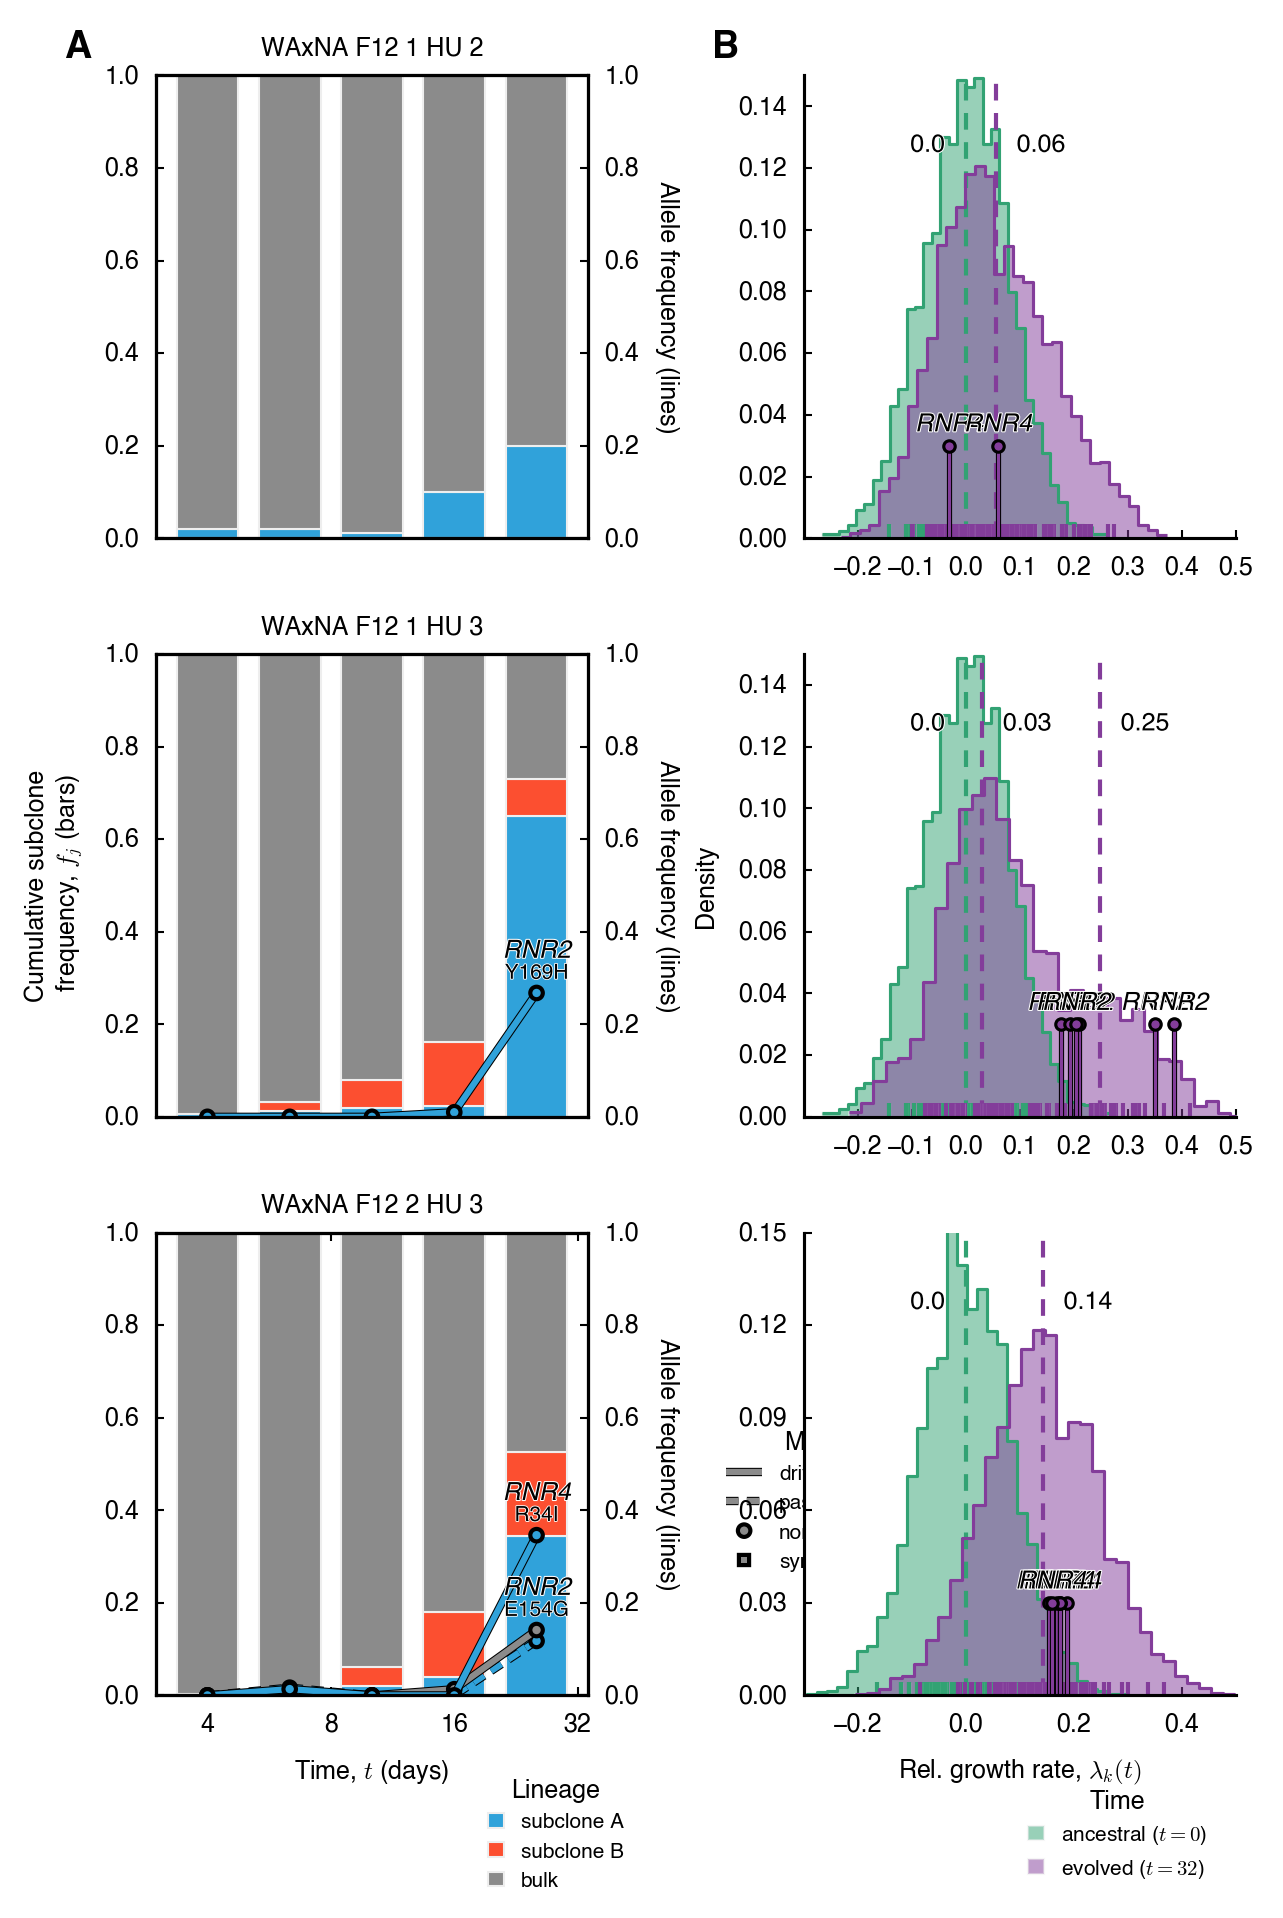

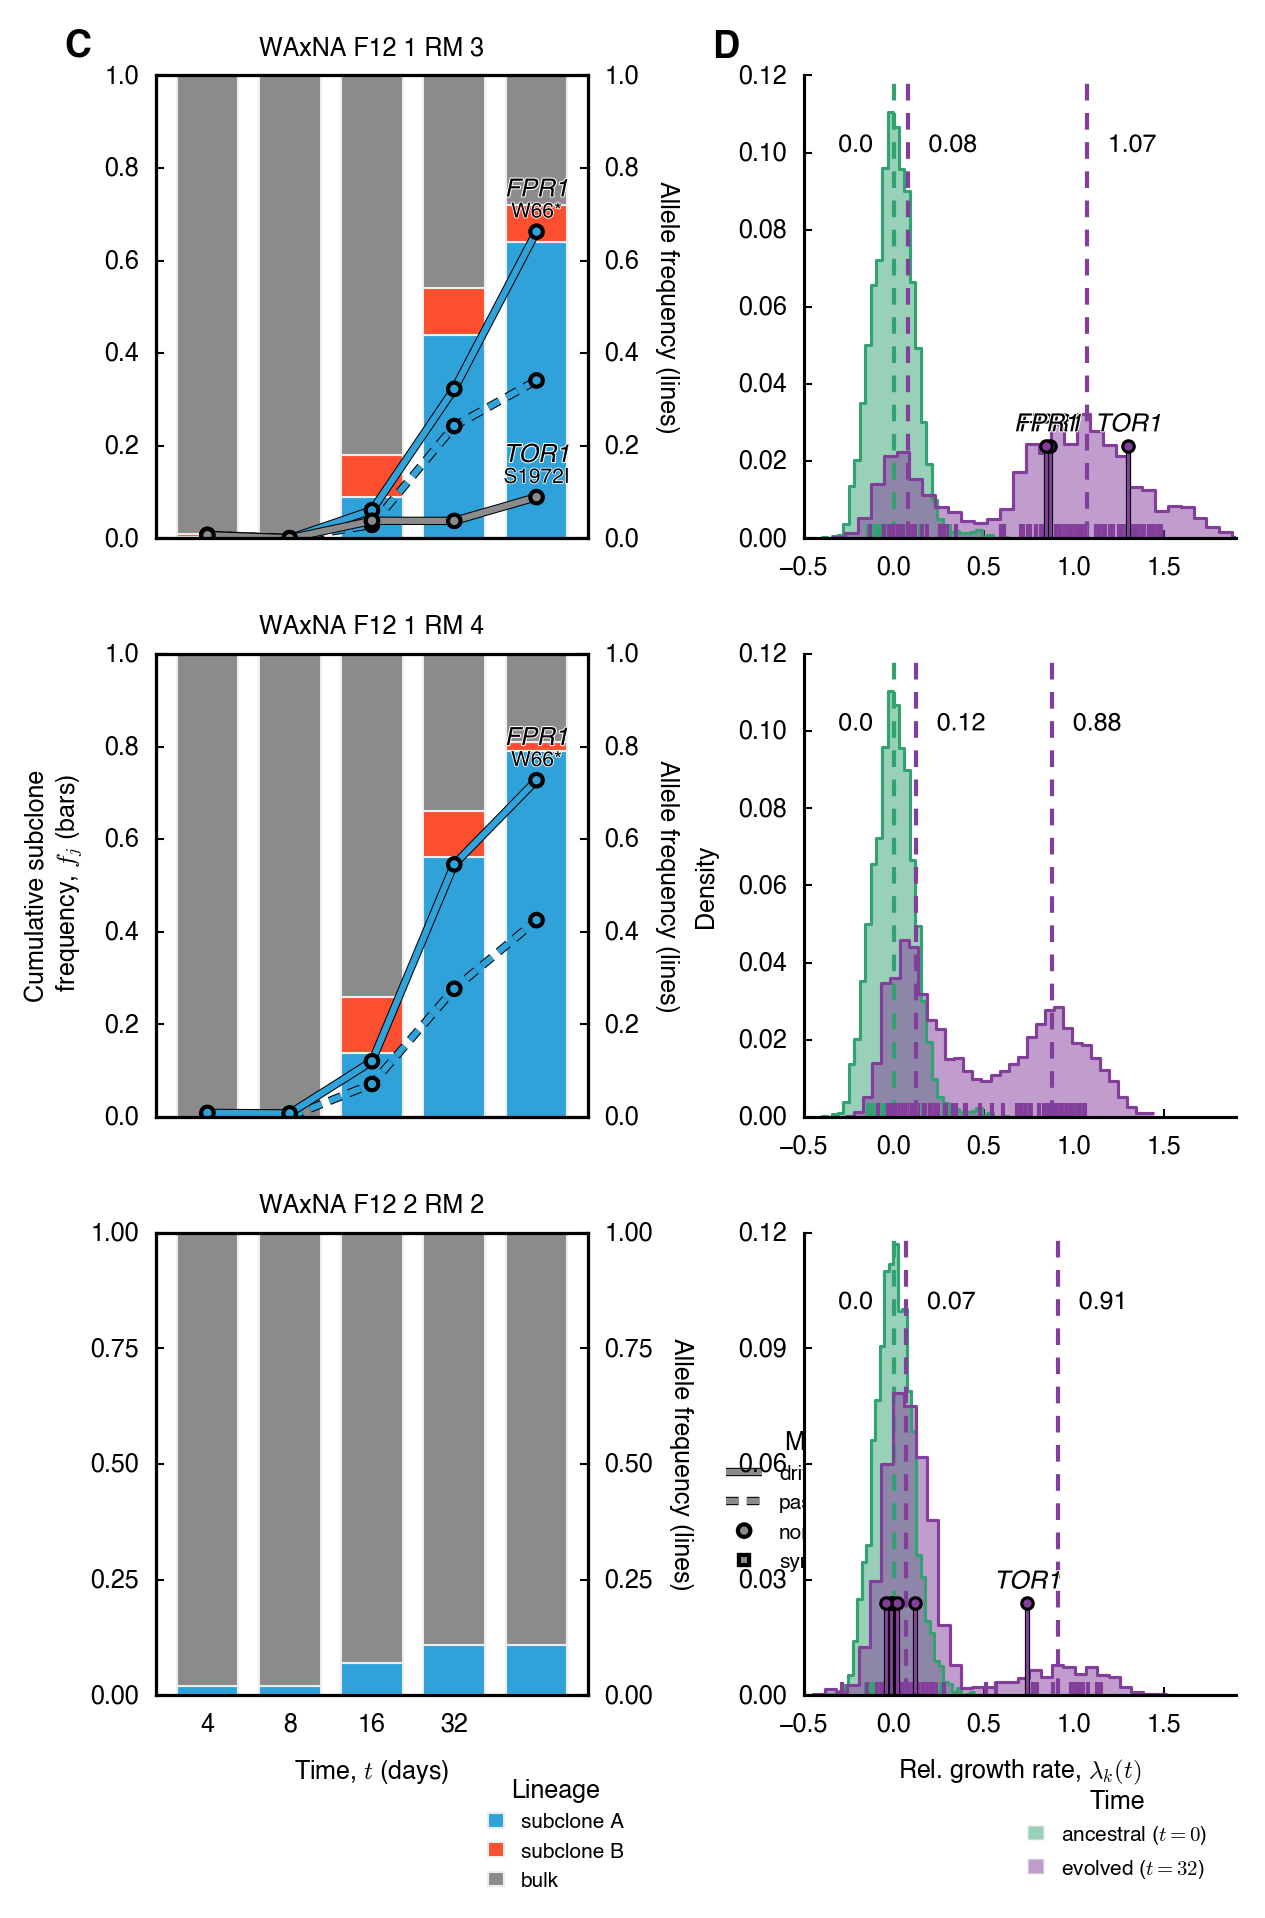

In [30]:
param = 'growth_rate'

panels = {
    'HU': {
        'WAxNA_F12_1_HU_2':0,
        'WAxNA_F12_1_HU_3':1,
        'WAxNA_F12_2_HU_3':2
    },
    'RM': {
        'WAxNA_F12_1_RM_3':0,
        'WAxNA_F12_1_RM_4':1,
        'WAxNA_F12_2_RM_2':2
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)]
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))&\
                      (seq_dn_df.clone=='')]
groups_ph = pheno_df[pheno_df.population.isin(populations)]

groups_st = groups_st.groupby('selection')
groups_dn = groups_dn.groupby('selection')
groups_ph = groups_ph.groupby(['selection','environment'])

for (ii, env) in enumerate(['HU','RM']):
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4, 6))#, sharey='col')
    
    fig.subplots_adjust(left=0.05,bottom=0.05,right=0.95,top=0.95,hspace=0.25,wspace=0.5)
    
    # set scales
    for ax in axes[:,0]:
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 1)
    for ax in axes[:,1]:
        if env=='HU':
            ax.set_xlim(-0.3, 0.5)
            ax.set_ylim(0, 0.15)
        elif env=='RM':
            ax.set_xlim(-0.5, 1.9)
            ax.set_ylim(0, 0.12)

    ### top panels ###
    # de novo mutations #
    for (jj, (population, gdn)) in enumerate(groups_dn.get_group(env).groupby('population')):
        
        # retrieve axes
        ax1 = axes[panels[env][population],0]
        
        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]
            
            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            
            ax1.plot(gdx.index.values, gdx.frequency.values,
                     color=config.lineages[assignment]['fill'], 
                     **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                             config.consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax1.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                             textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax1.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                             xy=(index,gdx.frequency[index]), fontsize=5,
                             textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)
    
    # subclonal frequency #
    for (jj, (population,gst)) in enumerate(groups_st.get_group(env).groupby('population')):

        # retrieve axes
        ax2 = axes[panels[env][population],0]

        # 
        ax2.set_title(population.replace('_',' '), fontsize=6)
        # 
        gst.set_index('time', inplace=True)
        colors=[config.lineages[x]['fill'] for x in ['subclone A','subclone B','bulk']]
        gst[['subclone A','subclone B','bulk']].plot(ax=ax2, kind='bar', legend=False, 
                                                     stacked=True, rot=0, width=0.75, position=0.5,
                                                     color=colors)
        
        # rotate the x-axis ticks
        ax2.set_xlabel('', rotation=0)
        ax2.twinx().set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')

    ### bottom panels ###
    for (jj, (population,gph)) in enumerate(groups_ph.get_group((env,env)).groupby('population')):

        # retrieve axes
        ax3 = axes[panels[env][population],1]
        utils.simple_axes(ax3)
        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
                                    
        for (kk, (time, g3)) in enumerate(gph.groupby('group')):
            
            x, y = plot.histogram_binned_data(ax, g3[param], bins=34)

            ax3.plot(x, y, color=config.population['color'][time], linewidth=0.75)
            
            ax3.fill_between(x, 0, y, label=config.population['long_label'][time], 
                             alpha=0.5, facecolor=config.population['color'][time])
            
            data_reduced = g3.groupby('isolate').agg([np.mean])
            X = data_reduced[param]['mean'][:, np.newaxis]
            N = np.arange(1, 6)
                        
            models = gmm.gmm_fit(X, N)
            
            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            M_best = models[np.argmin(BIC)]
        
            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                ax3.plot( [p,p], ax3.get_ylim(), 
                         color=config.population['color'][time], 
                         linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax3.get_ylim()[0] * 0.75 + ax3.get_ylim()[1] * 0.25
                trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction                    
                ax3.annotate(np.around(p, 2),
                            xy=(p, 0.85), xycoords=trans, fontsize=6,
                            color='k', va='center',
                            ha=('right' if time=='ancestral' else 'left'),
                            xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
            
            data_ns = g3.groupby(['isolate']).agg([np.mean, np.median, np.std, 'count'])
            
            x_data = np.array(data_ns[param]['mean'])
            y_data = np.repeat([0.03*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
            
            markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                            
            plt.setp(markerline, 'markerfacecolor', config.population['color'][time], markersize = 0)
            plt.setp(stemlines, linewidth=1, color=config.population['color'][time], 
                     path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")])
            plt.setp(baseline, 'color', 'none')

            # mean of sequenced isolates       
            data_ys = g3[(g3['group']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.2*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
            
                markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.population['color'][time],
                         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
            for idx, label in data_ys.iterrows():
                ax3.annotate(label.name[1], 
                             xy = (label[param]['mean'], 0.2), xycoords=('data','axes fraction'), 
                             xytext = (0, 8), textcoords = 'offset points', 
                             ha = 'center', va = 'top',
                             fontsize = 6, style = 'italic',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
        
    # set axes labels
    axes[2,0].set_xlabel(r'Time, $t$ (days)')
    axes[1,0].set_ylabel('Cumulative subclone\n frequency, $f_j$ (bars)')
    axes[2,1].set_xlabel(r'Rel. growth rate, $\lambda_{k}(t)$')
    axes[1,1].set_ylabel('Density')

    # set legends
    leg1 = axes[2,0].legend(bbox_to_anchor=(0.75, -0.3), frameon=False,
                            loc='center left', borderaxespad=0.,
                            handlelength=0.75, title='Lineage', prop={'size':5})

    driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                 **config.mutation_type['driver'])
    passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                    **config.mutation_type['passenger'])
    nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                                 linestyle='', linewidth=1.5,
                                 path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                 **config.consequence_short['non-synonymous'])
    syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                              linestyle='', linewidth=1.5,
                              path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")], 
                              **config.consequence_short['synonymous'])
    leg2 = axes[2,0].legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                            ['driver','passenger','non-synonymous','synonymous'], 
                            bbox_to_anchor=(1.3, 0.25), ncol=1,
                            frameon=False, loc='lower left',
                            borderaxespad=0, handlelength=1.75, 
                            title='Mutation', prop={'size':5})
    axes[2,0].add_artist(leg1)
    
    leg3 = axes[2,1].legend(bbox_to_anchor=(0.5, -0.3), frameon=False, 
                            loc='center left', borderaxespad=0., framealpha=1,
                            handlelength=0.75, title='Time', prop={'size':5})
    
    for leg in [leg1,leg2,leg3]:
        plt.setp(leg.get_title(), fontsize=6)
    
    # set panel labels
    axes[0,0].text(-0.15, 1.1,  chr(2*ii + ord('A')), transform=axes[0,0].transAxes,
                   fontsize=9, fontweight='bold', va='top', ha='right')
    axes[0,1].text(-0.15, 1.1,  chr(2*ii + ord('B')), transform=axes[0,1].transAxes,
                   fontsize=9, fontweight='bold', va='top', ha='right')

    # axes limits
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        ax.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
        for loc in ['top','bottom','left','right']:
            ax.spines[loc].set_linewidth(0.75)
        
        if ax.is_last_row():
            if env=='HU':
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
            elif env=='RM':
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.png' % env, bbox_inches='tight')
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.svg' % env, bbox_inches='tight')
    plt.show()

## Figure S3 - Sequence evolution of WA, NA founders

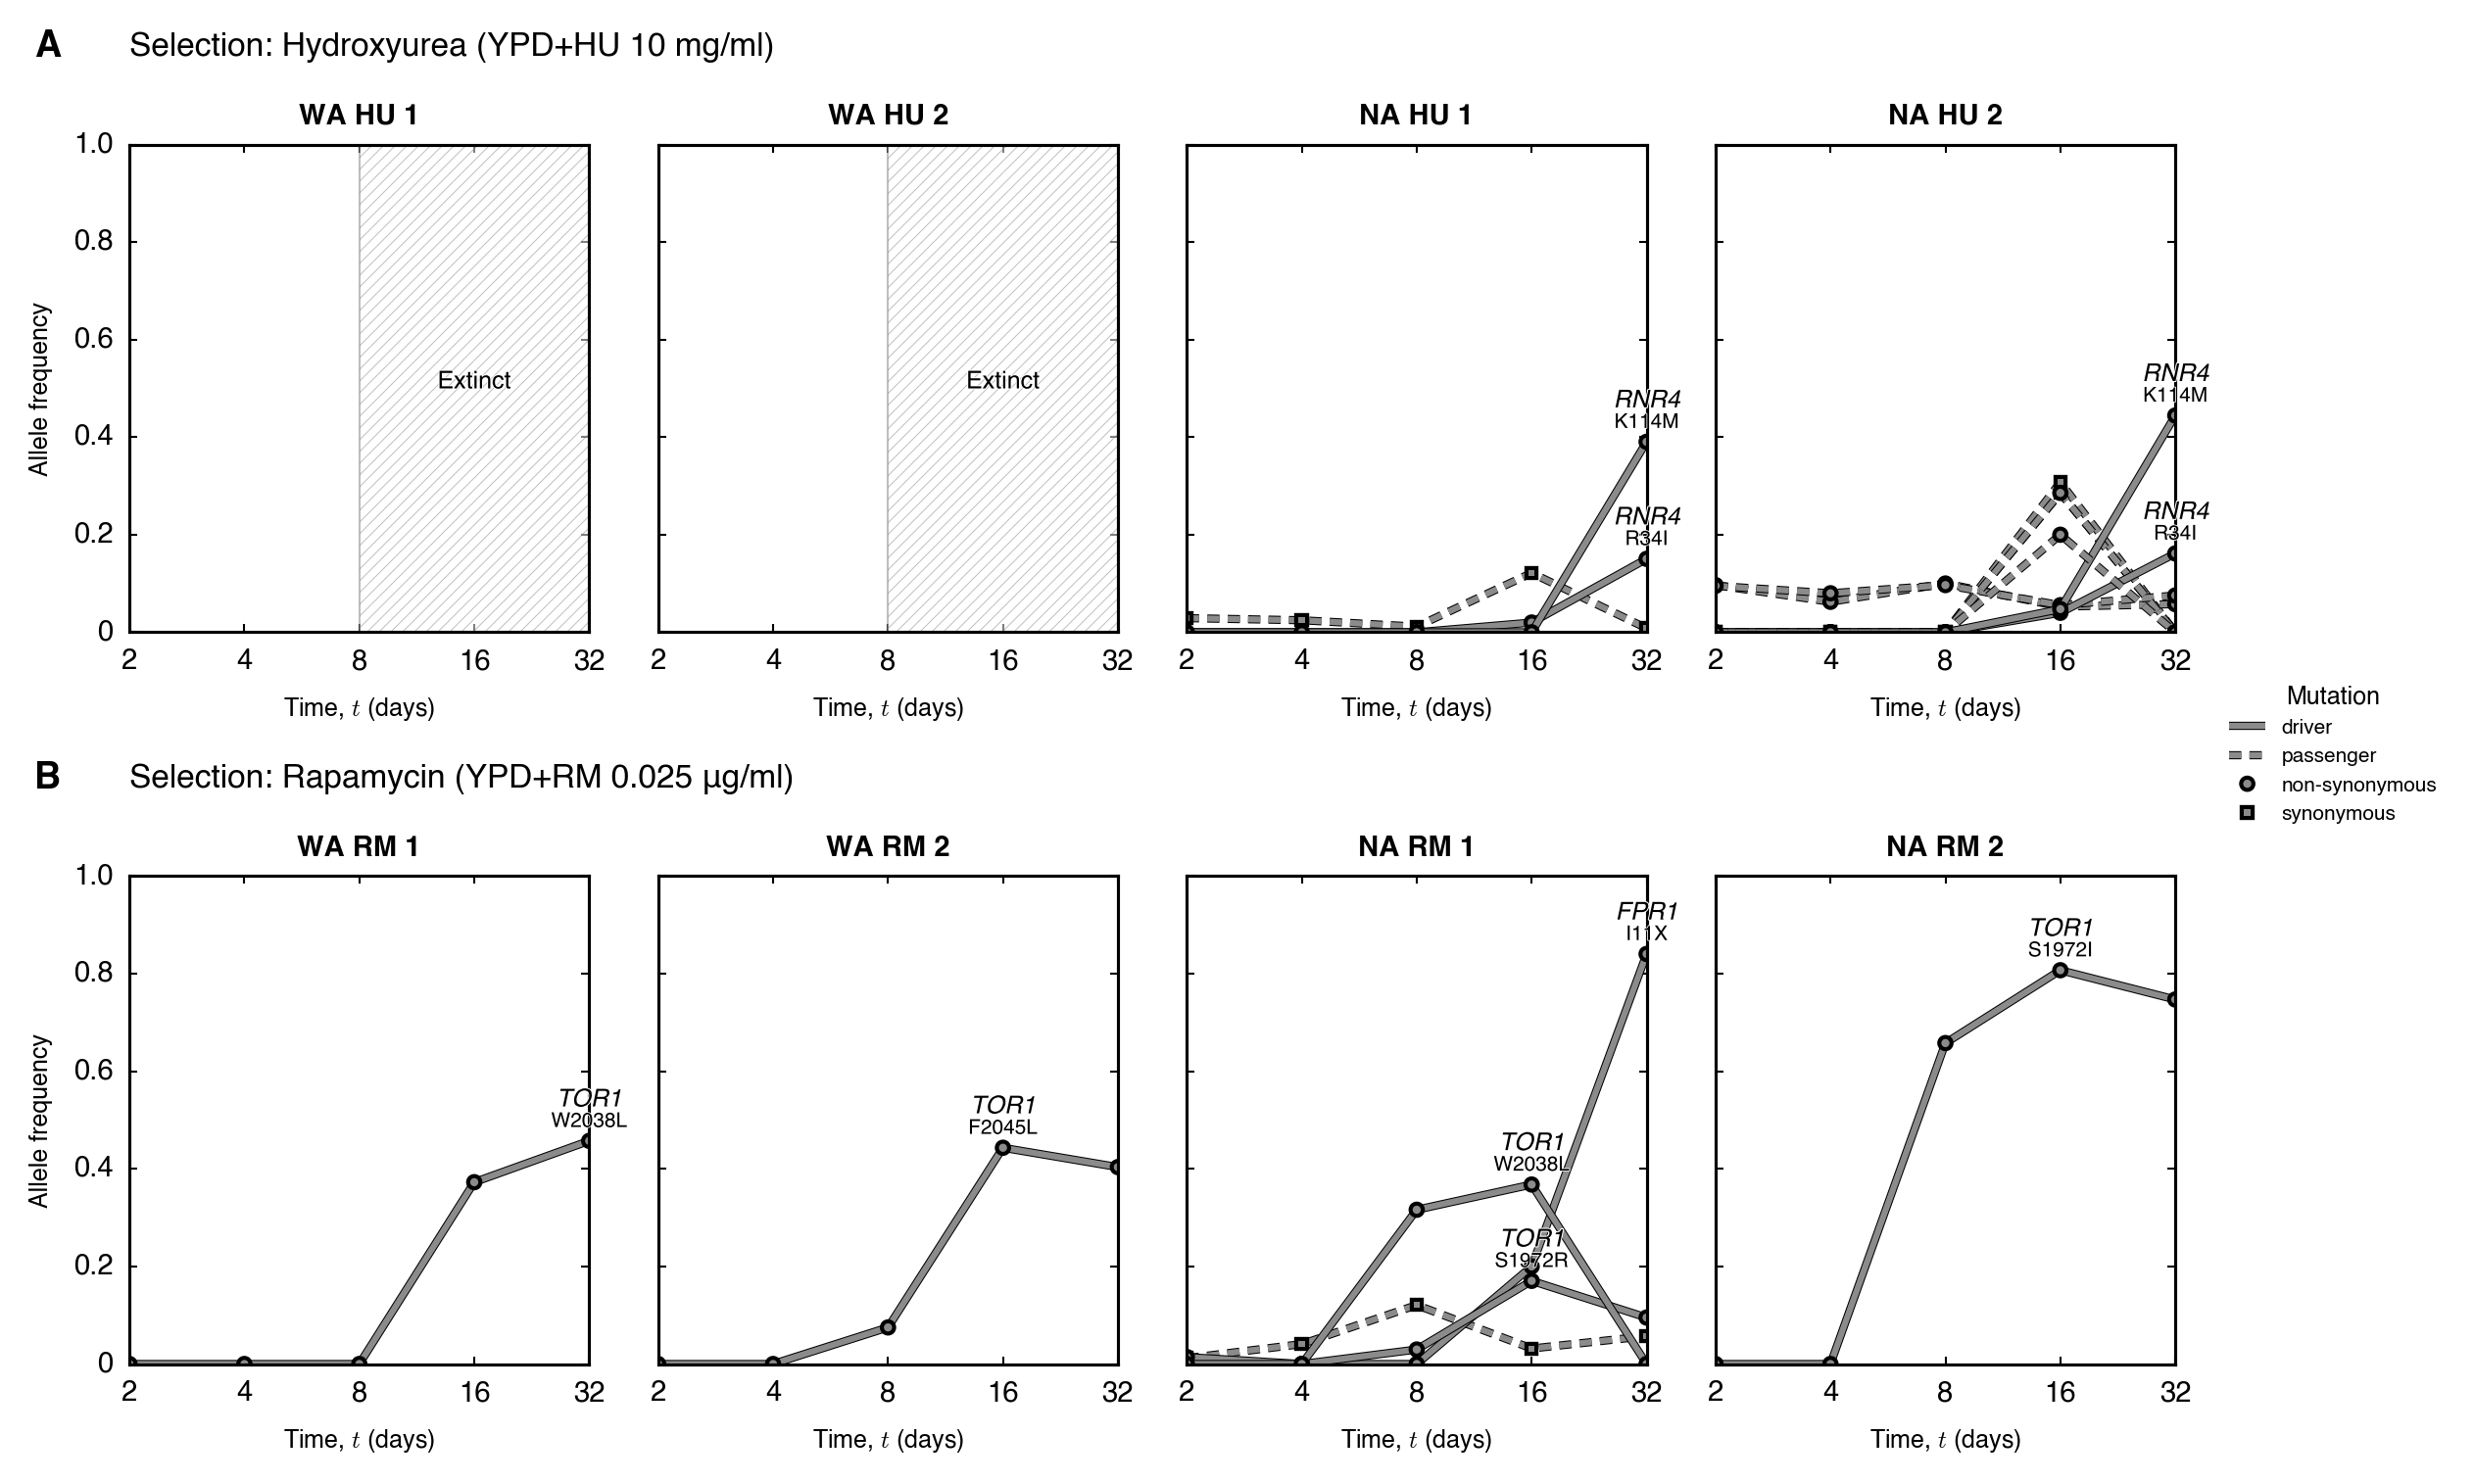

In [30]:
panels = {
    'HU': {
        'WA_HU_1':(0,0),
        'WA_HU_2':(0,1),
        'NA_HU_1':(0,2),
        'NA_HU_2':(0,3),
    },
    'RM': {
        'WA_RM_1':(0,0),
        'WA_RM_2':(0,1),
        'NA_RM_1':(0,2),
        'NA_RM_2':(0,3),
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations)) & \
                      (seq_dn_df.clone=='')].groupby(['selection','population'])

# get a figure with a lot of subplots
fig = plt.figure(figsize=(8, 5))

grid = gridspec.GridSpec(2, 1, hspace=0.5)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 1
    ncols = 4
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             wspace=0.15)

    ### de novo mutations ###
    for (jj, p) in enumerate(panels[e].keys()):
        
        # retrieve axes
        ax = plt.subplot(gs[e][panels[e][p]])
        ax.set_title(p.replace('_',' '), fontsize=7, weight='bold')
    
        # set axes labels
        if (e,p) in [('HU','WA_HU_1'),('RM','WA_RM_1')]:
            ax.set_ylabel('Allele frequency')
            ax.text(-0.15, 1.2, chr(ii + ord('A')), transform=ax.transAxes,
                    fontsize=9, fontweight='bold', va='center', ha='right')
            ax.text(0, 1.2, 'Selection: %s' % config.selection['long_label'][e], 
                    transform=ax.transAxes, fontsize=8, va='center', ha='left')
            ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
        else:
            ax.set_yticklabels([])
        ax.set_xlabel(r'Time, $t$ (days)')
        
        # set legend
        if (e,p) in [('HU','NA_HU_2')]:
            driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                         **config.mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                            **config.mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='',
                                         path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                         **config.consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                      **config.consequence_short['synonymous'])
            leg1 = ax.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.1, -0.25), ncol=1,
                             frameon=False, loc='center left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
            plt.setp(leg1.get_title(),fontsize=6)
        
        # set empty panels
        if (e,p) in groups_dn.groups.keys():
            gdn = groups_dn.get_group((e,p))
        else:
            ax.axvspan(8, 32, facecolor='w', edgecolor='0.5', alpha=0.5, hatch='//')
            ax.annotate('Extinct', xy=(16,0.5), fontsize=6, ha='center',
                        path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
            continue

        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]

            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            gdx = gdx.set_index('time')
            
            ax.plot(gdx.index, gdx.frequency,
                    color=config.lineages['bulk']['line'], 
                    **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                            config.consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                            textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                            xy=(index,gdx.frequency[index]), fontsize=5,
                            textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                            path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)

for ax in fig.get_axes():
        
    ax.set_xlim(2, 32) # axes limits
    ax.set_ylim(0, 1)
    
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
    ax.set_xscale('log', base=2)
    ax.set_xticks([2, 4, 8, 16, 32])
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        
    plt.setp(ax.get_xticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)

fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_parents.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_parents.svg', bbox_inches='tight')
plt.show()

**Fig. S3:** Subclonal dynamics in time for WA and NA founders evolved in (**A**) hydroxyurea and (**B**) rapamycin, measured by whole-population sequencing. WA founders evolved in hydroxyurea did not survive after 4 days. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. No *de novo* mutations were detected in any of the control replicates in YPD.

## Figure S4 - Sequence evolution of WAxNA founders

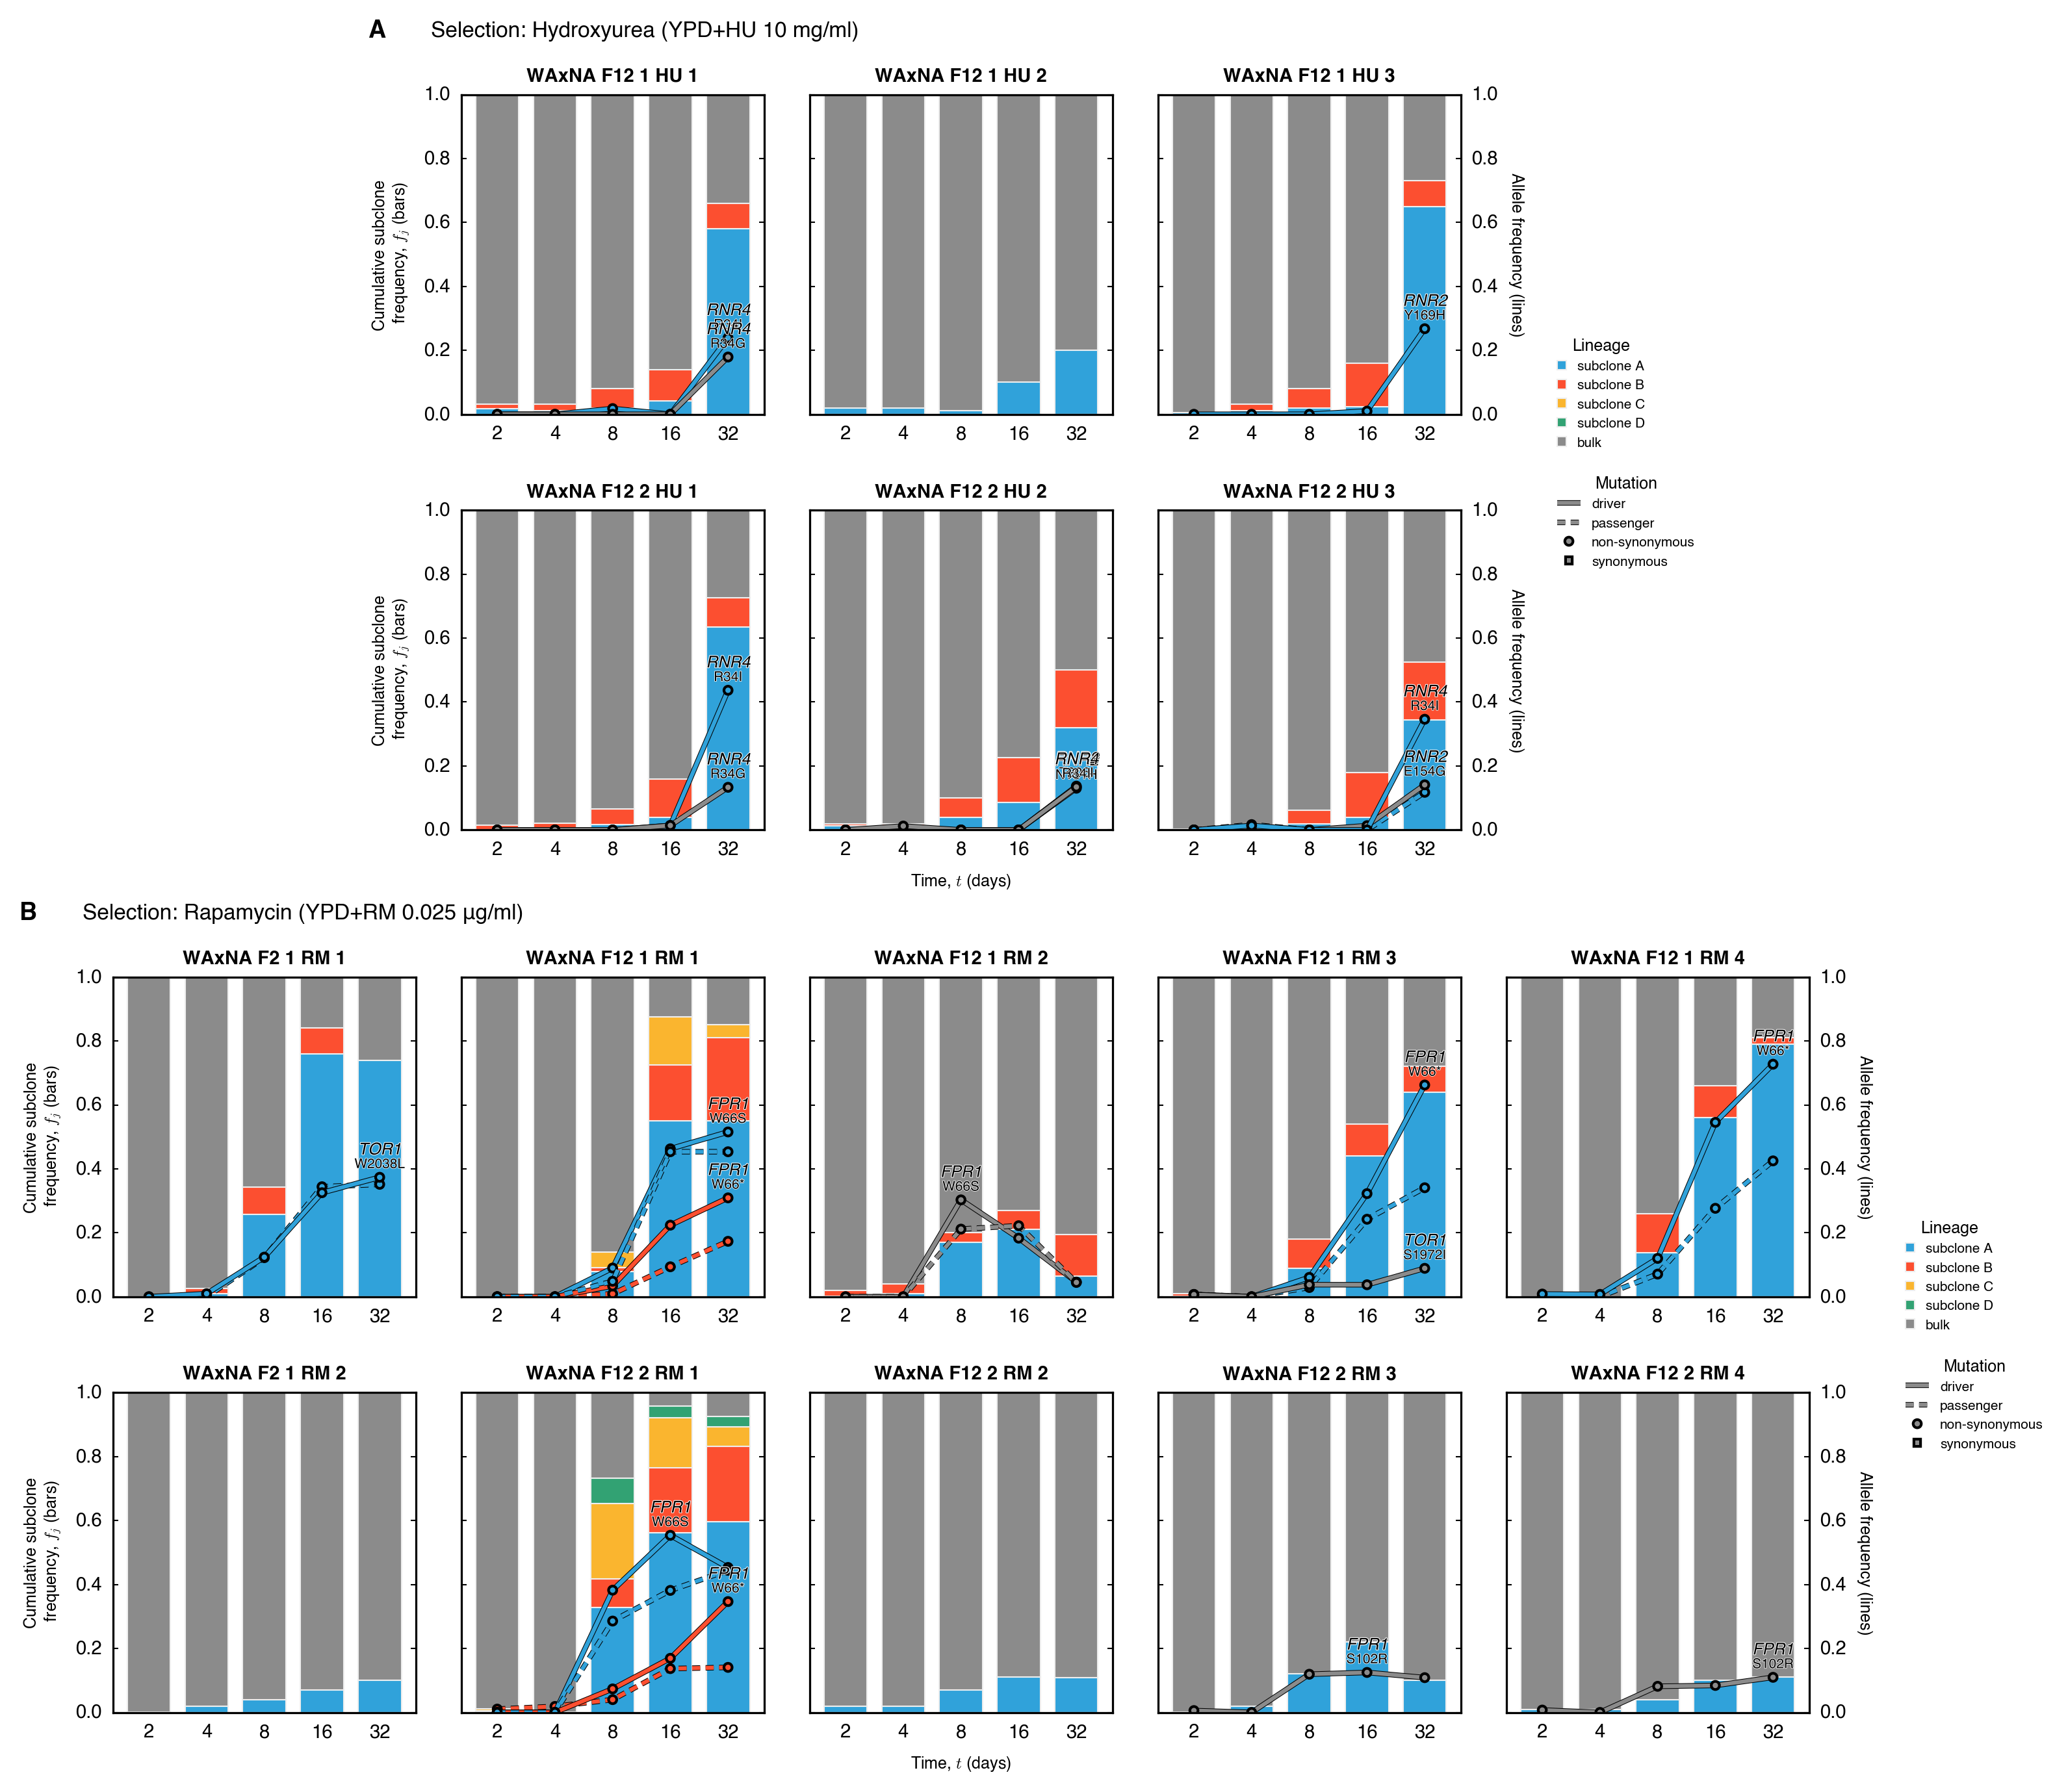

In [29]:
panels = {
    'HU': {
        'WAxNA_F12_1_HU_1':(0,1), 
        'WAxNA_F12_1_HU_2':(0,2), 
        'WAxNA_F12_1_HU_3':(0,3), 
        'WAxNA_F12_2_HU_1':(1,1), 
        'WAxNA_F12_2_HU_2':(1,2), 
        'WAxNA_F12_2_HU_3':(1,3)
    },
    'RM': {
        'WAxNA_F2_1_RM_1':(0,0),
        'WAxNA_F12_1_RM_1':(0,1), 
        'WAxNA_F12_1_RM_2':(0,2), 
        'WAxNA_F12_1_RM_3':(0,3), 
        'WAxNA_F12_1_RM_4':(0,4),
        'WAxNA_F2_1_RM_2':(1,0),
        'WAxNA_F12_2_RM_1':(1,1), 
        'WAxNA_F12_2_RM_2':(1,2), 
        'WAxNA_F12_2_RM_3':(1,3), 
        'WAxNA_F12_2_RM_4':(1,4)
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)].groupby(['selection','population'])
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))&\
                      (seq_dn_df.clone=='')].groupby(['selection','population'])

# get a figure with a lot of subplots
fig = plt.figure(figsize=(10, 10))

grid = gridspec.GridSpec(2, 1)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 2
    ncols = 5
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0.3, wspace=0.15)
    
    for (jj, p) in enumerate(panels[e]):
        
        # retrieve axes
        ax1 = plt.subplot(gs[e][panels[e][p]])
        ax2 = ax1.twinx()
                    
        ### subclone frequency ###
        gst = groups_st.get_group((e,p))
        
        # set title
        ax1.set_title(p.replace('_',' '), fontsize=7, weight='bold')

        # bar plot
        gst = gst.set_index('time')
        gst = gst[['subclone A','subclone B','subclone C','subclone D','bulk']]
        gst.plot(ax=ax1, kind='bar',
                 legend=False, stacked=True, width=0.75, position=0.5,
                 color=[config.lineages[c]['fill'] for c in gst.columns])
        
        ### de novo mutations ###
        if (e,p) in groups_dn.groups.keys():

            gdn = groups_dn.get_group((e,p))
            
            for (gene, pos, cds, sub, protein_pos, amino_acids, consequence), gdx \
            in gdn.groupby(['gene','pos','cds_position','substitution',\
                            'protein_position','amino_acids','consequence_short']):
                
                assignment = gdx.assignment.unique()[0]
                mutation_type = gdx.mutation_type.unique()[0]
            
                gdx = gdx.sort_values('time').reset_index(drop=True)
                gdx = gdx.sort_index()

                ax2.plot(gdx.index.values, gdx.frequency.values,
                         color=config.lineages[assignment]['line'],
                         **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                                 config.consequence_short[consequence]))

                if mutation_type=='driver':
                    index = np.argmax(gdx.frequency)
                    ax2.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                                 textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                                 path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                    ax2.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                                 xy=(index,gdx.frequency[index]), fontsize=5,
                                 textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                                 path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)
        
        # set legends
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4')]:
            
            leg1 = ax1.legend(bbox_to_anchor=(1.3, -0.125), ncol=1,
                              frameon=False, loc='lower left', 
                              borderaxespad=0., handlelength=0.7, 
                              title='Lineage', prop={'size':5})
    
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            
            driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                         **config.mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                            **config.mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='',
                                         path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                         **config.consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                      **config.consequence_short['synonymous'])
            leg2 = ax1.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                              ['driver','passenger','non-synonymous','synonymous'], 
                              bbox_to_anchor=(1.3, 1.125), ncol=1,
                              frameon=False, loc='upper left',
                              borderaxespad=0, handlelength=1.75, 
                              title='Mutation', prop={'size':5})
            
        for leg in [leg1,leg2]:
            plt.setp(leg.get_title(),fontsize=6)

        # set axes labels
        if (e,p) in [('HU','WAxNA_F12_2_HU_2'),('RM','WAxNA_F12_2_RM_2')]:
            ax1.set_xlabel(r'Time, $t$ (days)')
        else:
            ax1.set_xlabel('')
        if (e,p) in [('HU','WAxNA_F12_1_HU_1'),('RM','WAxNA_F2_1_RM_1'),
                     ('HU','WAxNA_F12_2_HU_1'),('RM','WAxNA_F2_1_RM_2')]:
            ax1.set_ylabel('Cumulative subclone\n frequency, $f_j$ (bars)')
        else:
            ax1.set_yticklabels([])
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4'),
                     ('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            ax2.set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
        else:
            ax2.set_yticklabels([])
        
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0) # rotate the x-axis ticks

        # set panel labels
        if (e,p) in [('HU','WAxNA_F12_1_HU_1'),('RM','WAxNA_F2_1_RM_1')]:
            ax1.text(-0.25, 1.2,  chr(ii + ord('A')), transform=ax1.transAxes,
                     fontsize=9, fontweight='bold', va='center', ha='right')
            ax1.text(-0.1, 1.2, 'Selection: %s' % config.selection['long_label'][e],
                     transform=ax1.transAxes, fontsize=8, va='center', ha='left')

for ax in fig.get_axes():
            
    ax.set_ylim(0, 1) # axes limits
    
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
            
    plt.setp(ax.get_xticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)

    for tk in ax.get_xticklabels():
        tk.set_visible(True)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(.75)

fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_cross.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_cross.svg', bbox_inches='tight')
plt.show()

**Fig. S4:** Subclonal dynamics in time for WAxNA founders evolved in (**A**) hydroxyurea and (**B**) rapamycin, measured by whole-population sequencing. Time is on the $x$-axis, starting after crossing when the population has no competing subclones. Cumulative haplotype frequency of subclones (bars) and allele frequency of *de novo* mutants (lines) are on the $y$-axis. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. No macroscopic subclones or *de novo* mutations were detected in any of the control replicates in YPD.

## Figure S7 - Phenotype evolution

We are inferring the model's components ($F, \lambda_1, \sigma_{\lambda_1}, \lambda_2, \sigma_{\lambda_2}$) using a Gaussian mixture model.

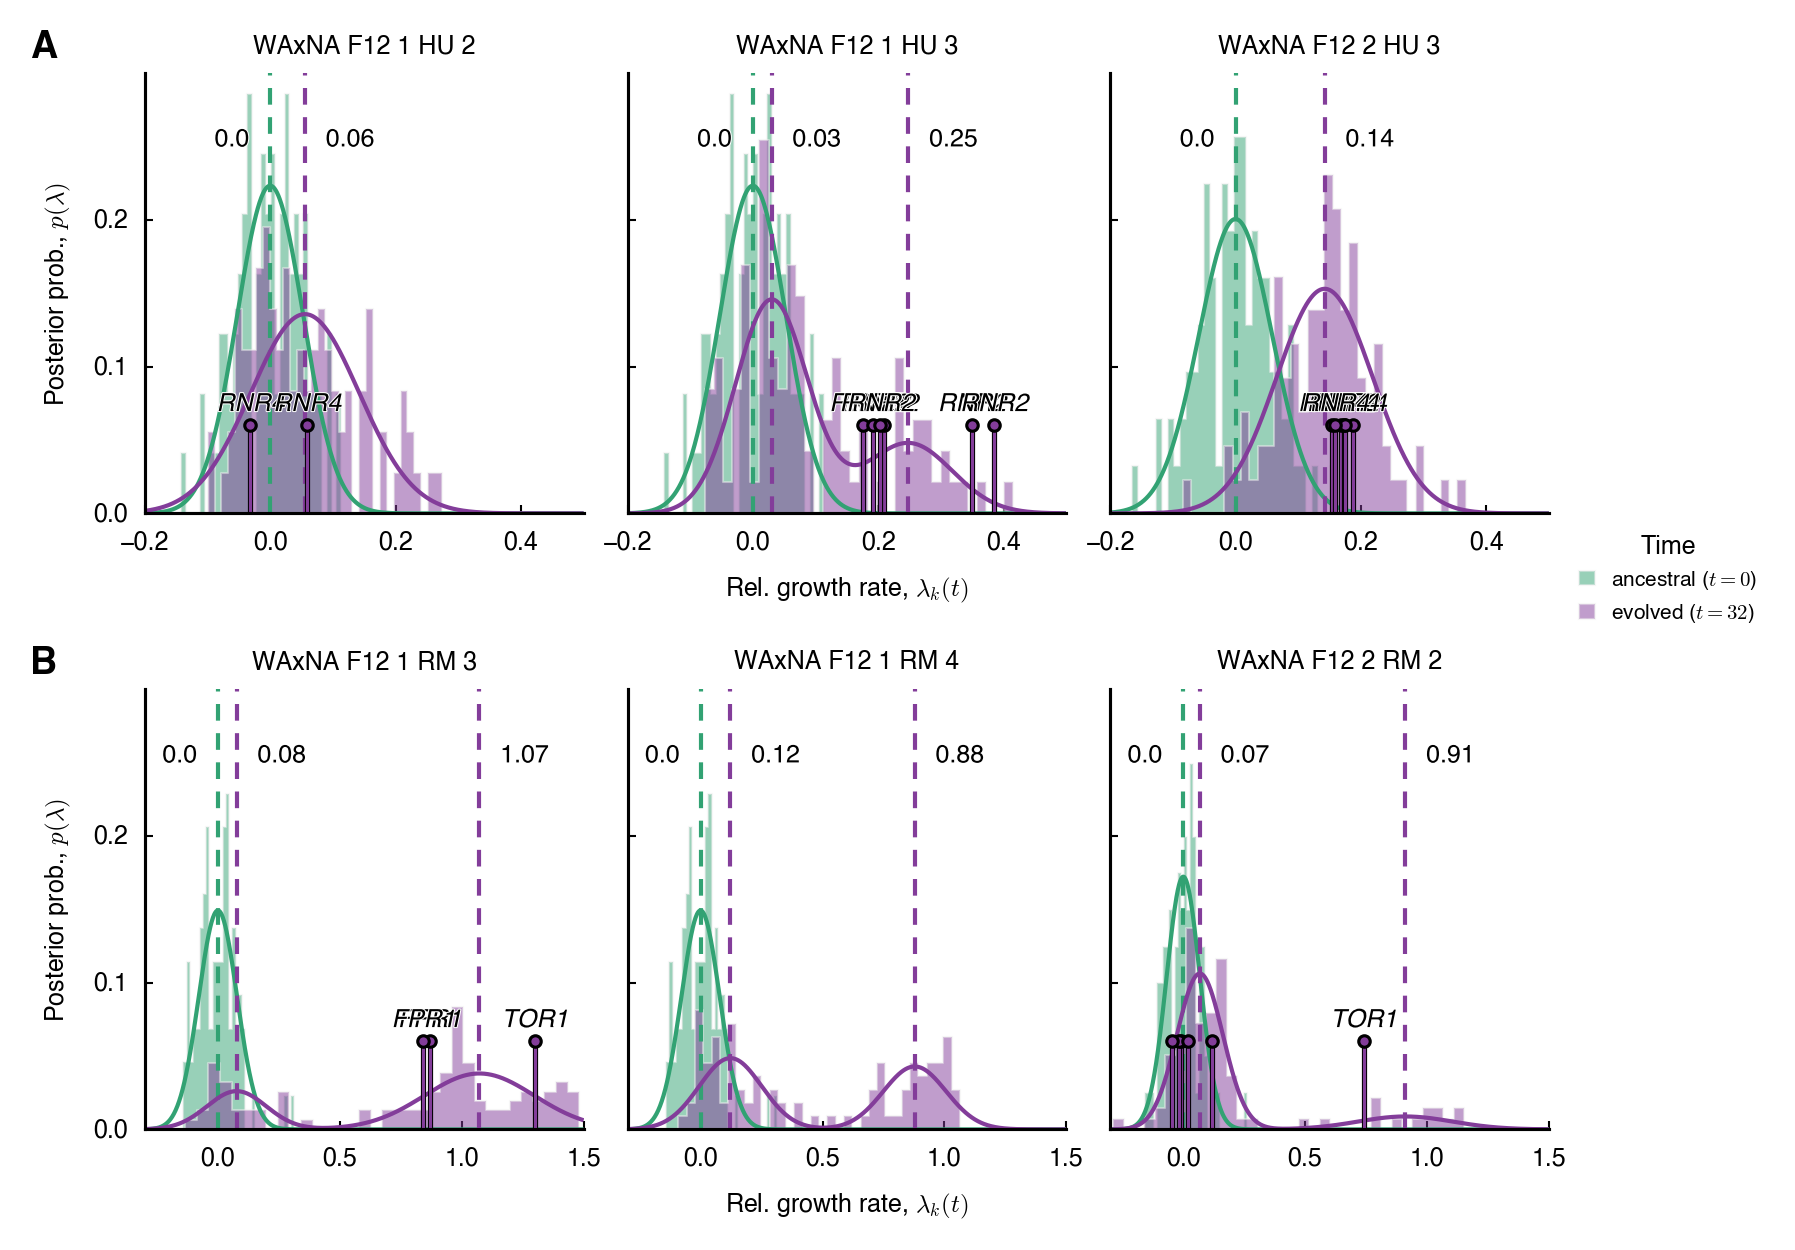

In [172]:
param = 'growth_rate'

panels = {
    'WAxNA_F12_1_HU_2':(0,0),
    'WAxNA_F12_1_HU_3':(0,1),
    'WAxNA_F12_2_HU_3':(0,2),
    'WAxNA_F12_1_RM_3':(1,0),
    'WAxNA_F12_1_RM_4':(1,1),
    'WAxNA_F12_2_RM_2':(1,2)
}

groups_ph = pheno_df[pheno_df.population.isin(panels.keys())]
groups_ph = groups_ph.groupby(['selection','environment'])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), sharex='row', sharey='row')
    
fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.4,wspace=0.1)

for (ii, env) in enumerate(['HU','RM']):
    
    for (jj, (population,gph)) in enumerate(groups_ph.get_group((env,env)).groupby('population')):
        
        # retrieve axes
        ax1 = axes[panels[population]]
        utils.simple_axes(ax1)
        if env=='HU':
            ax1.set_xlim(-0.2, 0.5)
            ax1.set_ylim(0, 0.3)
        elif env=='RM':
            ax1.set_xlim(-0.3, 1.5)
            ax1.set_ylim(0, 0.3)

        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
                
        for (kk, ((time),g3)) in enumerate(gph.groupby('group')):
            
            data = g3.groupby(['isolate']).agg([np.mean])
            X = data[param]['mean'][:, np.newaxis]
            
            # fit the Gaussian mixture model
            N = np.arange(1, 6)
            models = gmm.gmm_fit(X, N)

            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            M_best = models[np.argmin(BIC)]

            ax1.set_title(population.replace('_',' '), fontsize=6)
            
            # plot data
            bins = 34
            xbins, y = plot.histogram_binned_data(ax1, X, bins=bins)
                        
            ax1.fill_between(xbins, 0, y, label=config.population['long_label'][time], 
                             alpha=0.5, facecolor=config.population['color'][time])
            
            xbins = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 1000)
            logprob = M_best.score_samples(np.array([xbins]).T)
            pdf = np.exp(logprob)
#             pdf_individual = responsibilities * pdf[:, np.newaxis] 
            
            ax1.plot(xbins, pdf / bins, '-', 
                     color=config.population['color'][time], lw=1)
#             ax1.plot(xbins, pdf_individual / bins, '-', 
#                      color=config.population['color'][time], lw=1)

            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                ax1.plot([p,p], ax.get_ylim(), 
                        color=config.population['color'][time], 
                        linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax1.get_ylim()[0] * 0.75 + ax1.get_ylim()[1] * 0.25
                trans = ax1.get_xaxis_transform() # x in data units, y in axes fraction
                ax1.annotate(np.around(p, 2),
                             xy=(p, 0.85), xycoords=trans, fontsize=6,
                             color='k', va='center',
                             ha=('right' if time=='ancestral' else 'left'),
                             xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
                
            # mean of sequenced isolates       
            data_ys = g3[(g3['group']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.2*(ax1.get_ylim()[1]-ax1.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
            
                markerline, stemlines, baseline = ax1.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.population['color'][time],
                         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
            for idx, label in data_ys.iterrows():
                ax1.annotate(label.name[1], 
                             xy = (label[param]['mean'], 0.2), xycoords=('data','axes fraction'), 
                             xytext = (0, 8), textcoords = 'offset points', 
                             ha = 'center', va = 'top',
                             fontsize = 6, style = 'italic',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])

# draw legend
leg = axes[0, 2].legend(bbox_to_anchor=(1.05, -0.15), frameon=False,
                        loc='center left', borderaxespad=0.,
                        handlelength=0.75, title='Time', prop={'size':5})
plt.setp(leg.get_title(),fontsize=6)

# set axes labels
for ii in [0, 1]:
    axes[ii, 1].set_xlabel(r'Rel. growth rate, $\lambda_{k}(t)$')
    axes[ii, 0].set_ylabel(r'Posterior prob., $p(\lambda)$')

# set panel labels
axes[0][0].text(-0.2, 1.1,  chr(ord('A')), transform=axes[0][0].transAxes,
                fontsize=9, fontweight='bold', va='top', ha='right')
axes[1][0].text(-0.2, 1.1,  chr(ord('B')), transform=axes[1][0].transAxes,
                fontsize=9, fontweight='bold', va='top', ha='right')
        
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)
        
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_heno_evolution.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution.svg', bbox_inches='tight')
plt.show()

**Fig. S7:** Variability in intra-population growth rate, estimated by random sampling of 96 individuals at initial (0 days, blue) and final time points (32 days, red) for populations evolved in (**A**) hydroxyurea and (**B**) rapamycin. The mean growth rate $\lambda$ per individual $k$ is shown, averaging over ${n\,{=}\,32}$ technical replicates per individual (see Fig. 2B, D). Using a Gaussian mixture model, we found the posterior probability of the mixture modes of the the best-fit mixture (solid lines). The posterior means of the distribution modes are indicated as dashed lines. The fitter individuals (pins) measured by targeted sampling and sequencing carry driver mutations. 

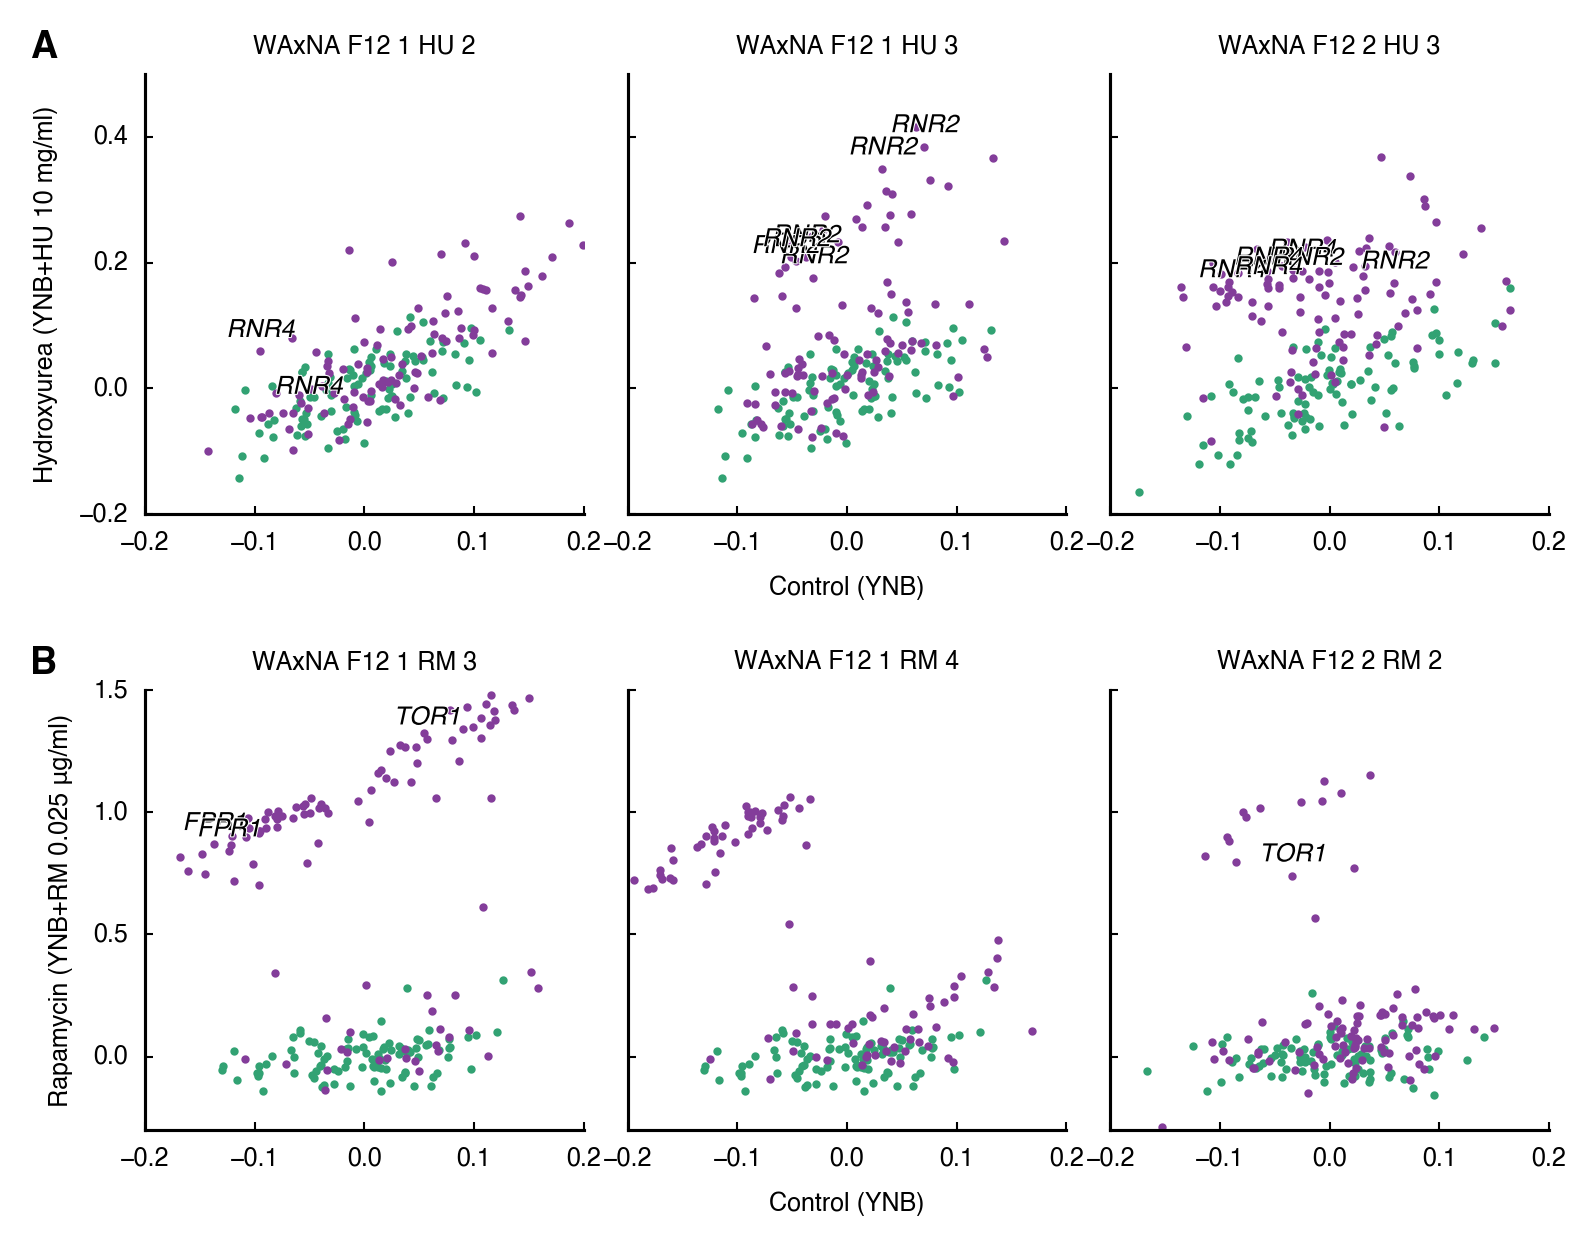

In [56]:
param='growth_rate'

dict_panels = {
    'WAxNA_F12_1_HU_2':0,
    'WAxNA_F12_1_HU_3':1,
    'WAxNA_F12_2_HU_3':2,
    'WAxNA_F12_1_RM_3':3,
    'WAxNA_F12_1_RM_4':4,
    'WAxNA_F12_2_RM_2':5,
}

data = pheno_df[pheno_df.population.isin(dict_panels.keys())]
data = pd.pivot_table(data, 
                      index=['selection','population','group','isolate','gene','genotype_long','assignment'], 
                      columns='environment', 
                      values=param)

corr = pheno_df[pheno_df.population.isin(dict_panels.keys())]
corr = pd.pivot_table(corr, 
                      index=['isolate','gene','genotype_long','assignment'], 
                      columns=['selection','population','group','environment'], 
                      values=param)
corr = corr.groupby(level=['selection','population','group'], axis=1, group_keys=False).apply(lambda x: x.corr(method='spearman'))
corr = corr.query('environment==\'YNB\'')
corr = pd.melt(corr).dropna()
corr = corr.pivot_table(columns=['group'], index=['selection','population','environment'], values='value')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), sharex='row', sharey='row')

fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.4,wspace=0.1)

### Scatter plot ###
for ii, ((s, p), gp) in enumerate(data.groupby(level=['selection','population'])):
    
    # retrieve axis
    ax = axes.flatten()[ii]
    utils.simple_axes(ax)
    
    if s=='HU':
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.2, 0.5)
    elif s=='RM':
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.3, 1.5)
    
    # set title
    ax.set_title(p.replace('_',' '), fontsize=6)
            
    for jj, (t, gt) in enumerate(gp.groupby(level='group')):
        
        ax.plot(gt['YNB'], gt[s], 
                marker='.', linestyle='', ms=3, 
                color=config.population['color'][t])#, label=config.population['long_label'][t])
    
    for labels, data in gp.query('gene!=\'\'').iterrows():
        ax.annotate(labels[-3], 
                    xy = (data['YNB'], data[s]), xycoords='data', 
                    xytext = (0, 8), textcoords = 'offset points', 
                    ha = 'center', va = 'top',
                    fontsize = 6, style = 'italic',
                    path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

# set axes labels
axes[0,1].set_xlabel(config.environment['long_label']['YNB'])
axes[0,0].set_ylabel(config.environment['long_label']['HU'])
axes[1,1].set_xlabel(config.environment['long_label']['YNB'])
axes[1,0].set_ylabel(config.environment['long_label']['RM'])

# set panel labels
axes[0,0].text(-0.2, 1.1,  chr(ord('A')), transform=axes[0,0].transAxes,
               fontsize=9, fontweight='bold', va='top', ha='right')
axes[1,0].text(-0.2, 1.1,  chr(ord('B')), transform=axes[1,0].transAxes,
               fontsize=9, fontweight='bold', va='top', ha='right')
# axes[0,-1].text(-0.2, 1.1,  chr(ord('B')), transform=axes[0,-1].transAxes,
#                 fontsize=9, fontweight='bold', va='top', ha='right')
# axes[1,-1].text(-0.2, 1.1,  chr(ord('D')), transform=axes[1,-1].transAxes,
#                 fontsize=9, fontweight='bold', va='top', ha='right')
    
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)
    
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))#, sharex='row', sharey='row')
        
# ### Rank correlation ###
# for ii, (e,c) in enumerate(corr.groupby(level='selection')):#.ix['HU']#.plot()
#     ax = axes.flatten()[ii]
#     utils.simple_axes(ax)
#     c = c.dropna(axis=1, how='all')
# #     c = c.dropna(how='all')
#     c.ix[e].plot(ax=ax, legend=False, style='.', 
#                  color=c.columns.map(lambda x: config.population['color'][x]))
    
#     # axes labels
#     ax.set_ylabel('Rank correlation')
#     # axes limits
#     ax.set_ylim((-1,1))
    
#     ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    
        
# # draw legend
# leg = axes[0, -1].legend(bbox_to_anchor=(1.05, -0.15), frameon=False,
#                          loc='center left', borderaxespad=0.,
#                          handlelength=0.75, title='Time', prop={'size':5})
# plt.setp(leg.get_title(),fontsize=6)

# # set axes labels
# axes[0,1].set_xlabel(config.environment['long_label']['YNB'])
# axes[0,0].set_ylabel(config.environment['long_label']['HU'])
# axes[1,1].set_xlabel(config.environment['long_label']['YNB'])
# axes[1,0].set_ylabel(config.environment['long_label']['RM'])

# # set panel labels
# axes[0,0].text(-0.2, 1.1,  chr(ord('A')), transform=axes[0,0].transAxes,
#                fontsize=9, fontweight='bold', va='top', ha='right')
# axes[1,0].text(-0.2, 1.1,  chr(ord('C')), transform=axes[1,0].transAxes,
#                fontsize=9, fontweight='bold', va='top', ha='right')
# axes[0,-1].text(-0.2, 1.1,  chr(ord('B')), transform=axes[0,-1].transAxes,
#                 fontsize=9, fontweight='bold', va='top', ha='right')
# axes[1,-1].text(-0.2, 1.1,  chr(ord('D')), transform=axes[1,-1].transAxes,
#                 fontsize=9, fontweight='bold', va='top', ha='right')

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)
    
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.svg', bbox_inches='tight')
plt.show()

In [57]:
corr

group                                   ancestral   evolved
selection population       environment                     
HU        WAxNA_F12_1_HU_2 HU            0.621229  0.758647
                           YNB           1.000000  1.000000
          WAxNA_F12_1_HU_3 HU            0.621229  0.426432
                           YNB           1.000000  1.000000
          WAxNA_F12_2_HU_3 HU            0.643150  0.137398
                           YNB           1.000000  1.000000
RM        WAxNA_F12_1_RM_3 RM            0.283763  0.332863
                           YNB           1.000000  1.000000
          WAxNA_F12_1_RM_4 RM            0.283763 -0.561286
                           YNB           1.000000  1.000000
          WAxNA_F12_2_RM_2 RM            0.104883  0.027860
                           YNB           1.000000  1.000000

0 HU WAxNA_F12_1_HU_2
1 HU WAxNA_F12_1_HU_3
2 HU WAxNA_F12_2_HU_3
3 RM WAxNA_F12_1_RM_3
4 RM WAxNA_F12_1_RM_4
5 RM WAxNA_F12_2_RM_2


KeyError: 'selection'

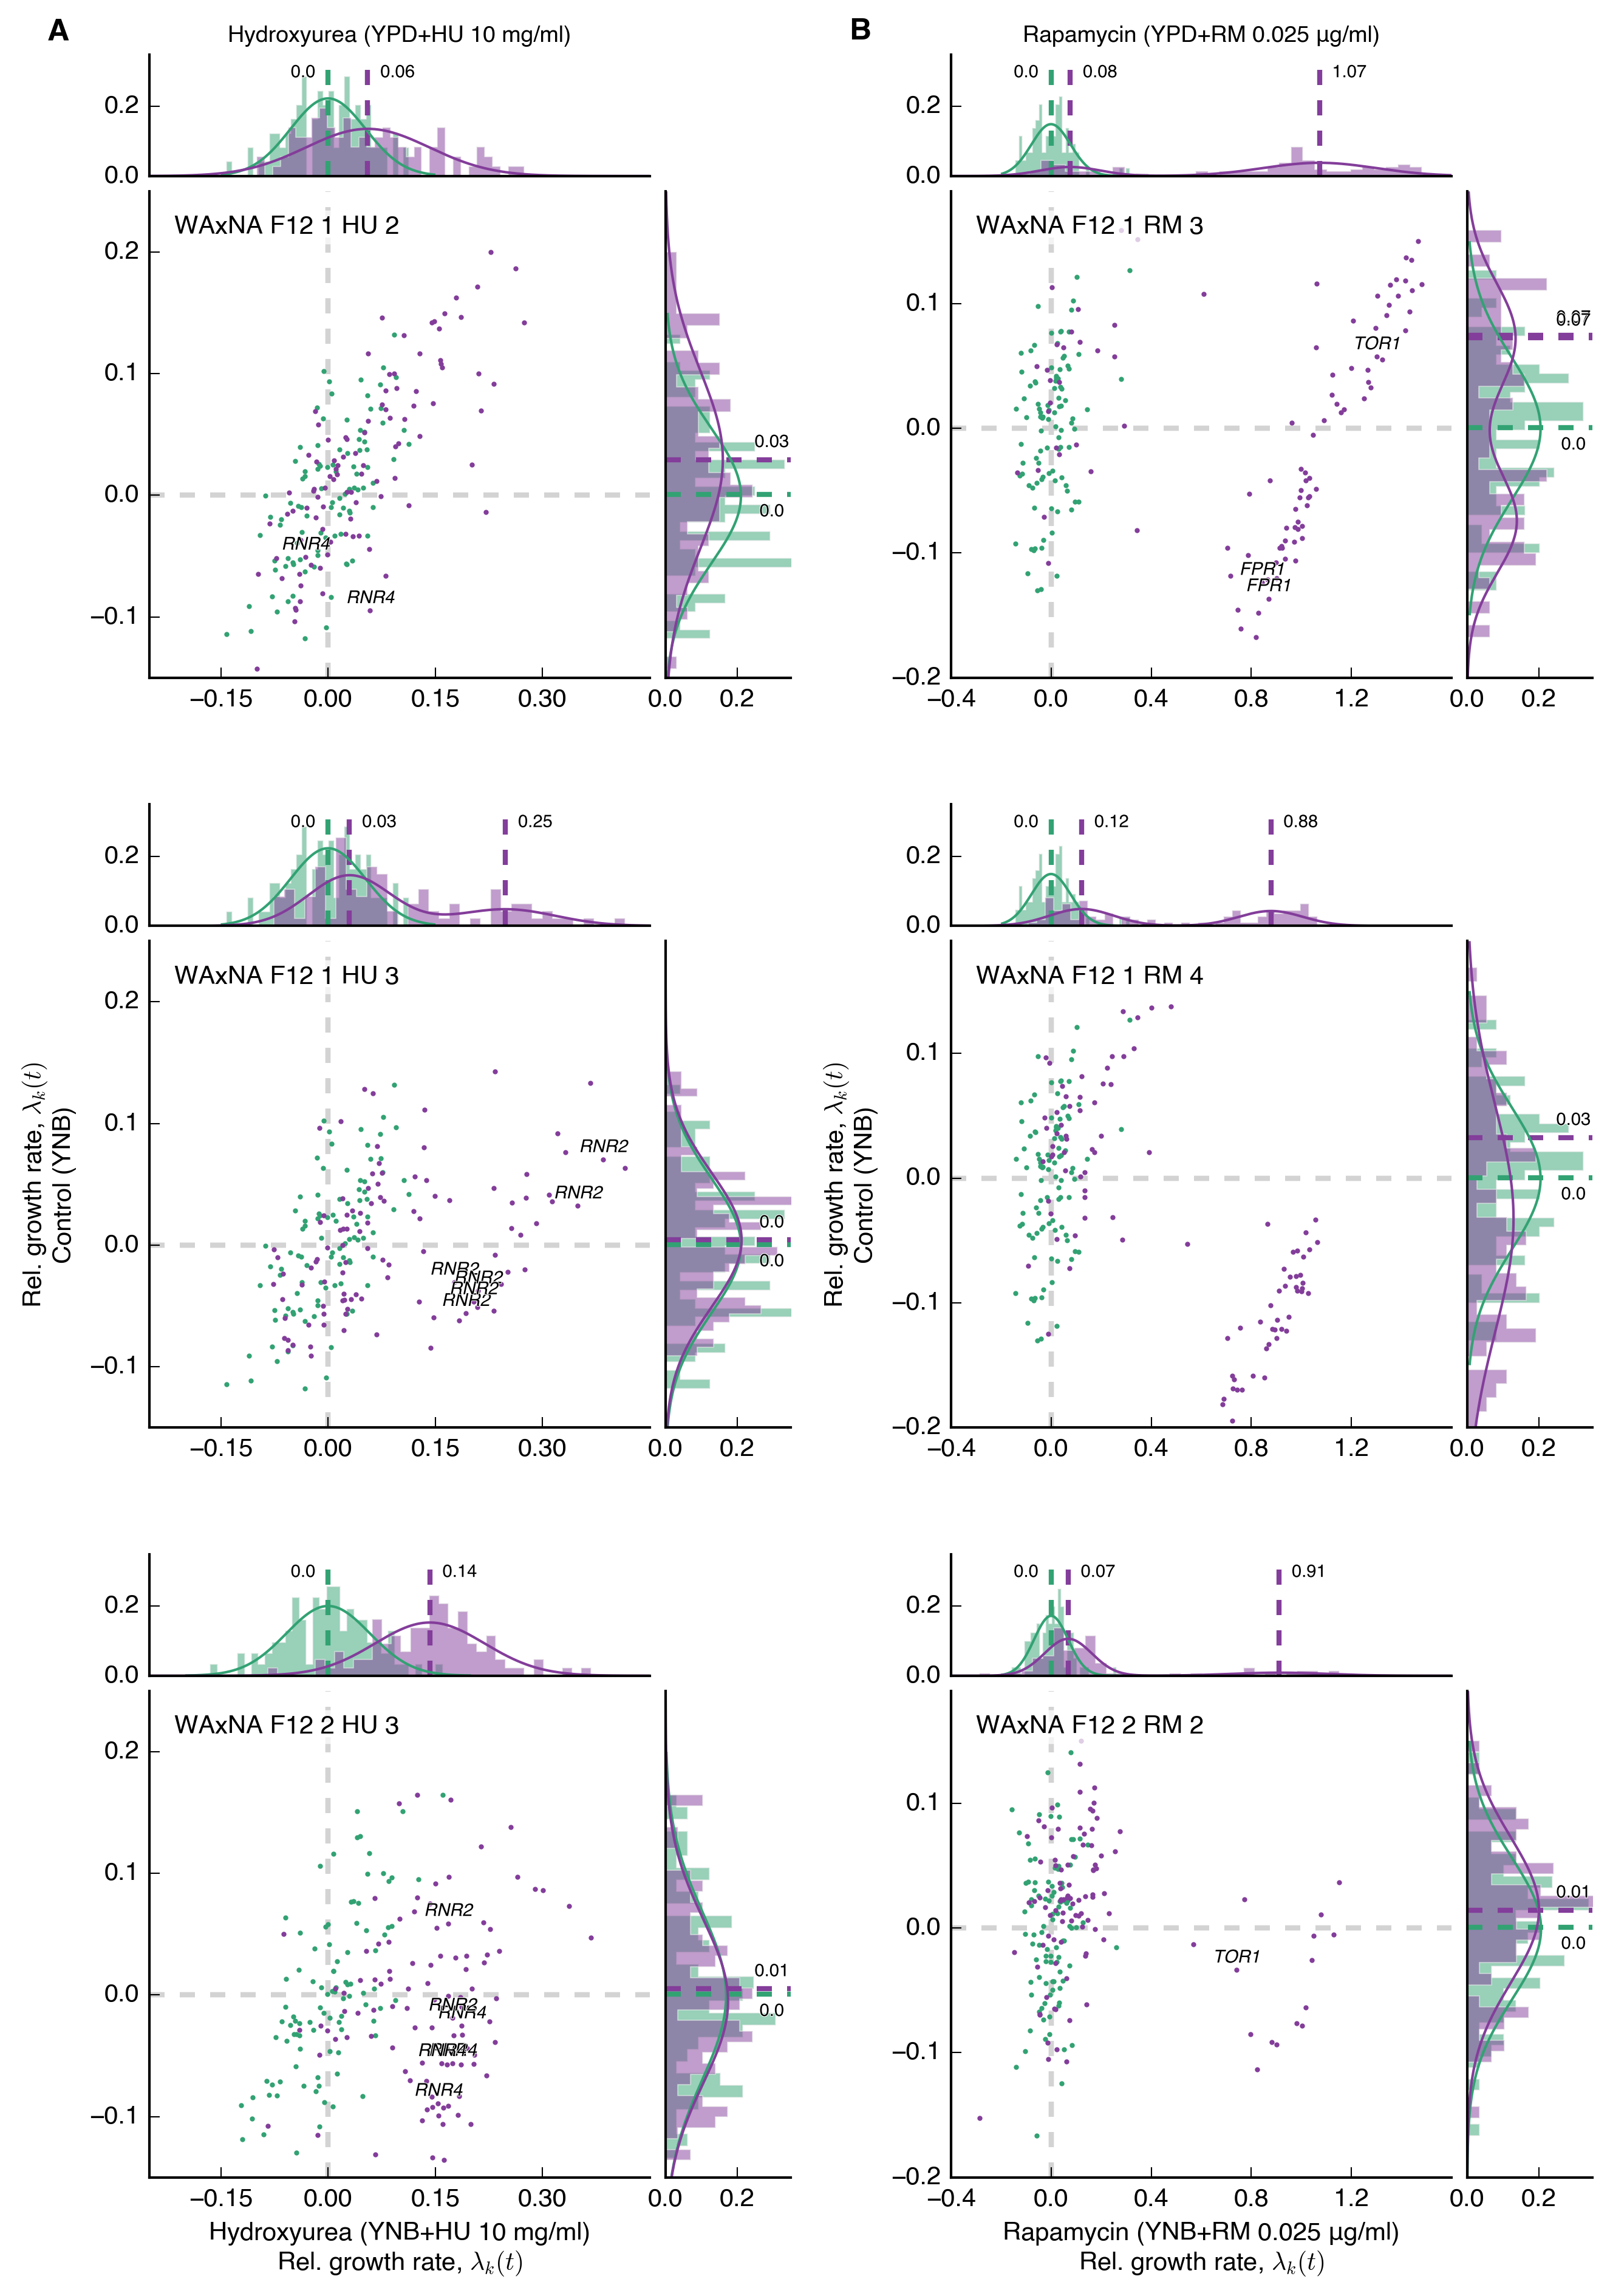

In [102]:
param='growth_rate'

panels = {
    'WAxNA_F12_1_HU_2':0,
    'WAxNA_F12_1_HU_3':2,
    'WAxNA_F12_2_HU_3':4,
    'WAxNA_F12_1_RM_3':1,
    'WAxNA_F12_1_RM_4':3,
    'WAxNA_F12_2_RM_2':5,
}

data = pheno_df[pheno_df.population.isin(panels.keys())]
data = pd.pivot_table(data, 
                      index=['selection','population','group','isolate','gene','genotype_long','assignment'], 
                      columns='environment', 
                      values=param)

corr = pheno_df[pheno_df.population.isin(panels.keys())]
corr = pd.pivot_table(corr, 
                      index=['isolate','gene','genotype_long','assignment'], 
                      columns=['selection','population','group','environment'], 
                      values=param)
corr = corr.groupby(level=['selection','population','group'], axis=1, group_keys=False).apply(lambda x: x.corr(method='spearman'))
corr = corr.query('environment==\'YNB\'')
corr = pd.melt(corr).dropna()
corr['population'] = corr['population'].apply(lambda x: x.replace('_',' '))
corr = corr.pivot_table(columns=['group'], index=['selection','population','environment'], values='value')
    
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(9,15))
fig.subplots_adjust(hspace=0.001, wspace=0.001, left=0.10, bottom=0.095, top=0.975, right=0.98)

# make outer gridspec
grid = gridspec.GridSpec(nrows=4, ncols=2, height_ratios=[4, 4, 4, 1], hspace=.25, wspace=.25) 

gs = {}

for ii, ((s, p), gp) in enumerate(data.groupby(level=['selection','population'])):
    print ii,s,p
    # gridspec enables you to assign different formats to panels in one plot.
    gs[(s,p)] = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, hspace=.05, wspace=.05, 
                                                 width_ratios=[4,1], height_ratios=[1,4], 
                                                 subplot_spec=grid[panels[p]])
    
    ax = plt.subplot(gs[(s,p)][:])
    ax_scatter = plt.subplot(gs[(s,p)][1,0])
    ax_x = plt.subplot(gs[(s,p)][0,0])
    ax_y = plt.subplot(gs[(s,p)][1,1])

    # Define plot ranges at beginning, since used often later
    x = gp['YNB'].values
    y = gp[s].values
    
    if s=='HU':
        x_range = [-0.25, 0.45]
        y_range = [-0.15, 0.25]
    elif s=='RM':
        x_range = [-0.4, 1.6]
        y_range = [-0.2, 0.19]

    # Set title
    ax_scatter.annotate(p.replace('_',' '),
                        xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
                        color='k', ha='left', va='top',
                        bbox=(dict(facecolor='white', edgecolor='none', 
                                   alpha=0.75, boxstyle='round,pad=.2')))

    for jj, (t, gt) in enumerate(gp.groupby(level='group')):
        
        gt_seq = gt.query('group==\'evolved\' & assignment!=\'\'').groupby(level=['isolate','gene','genotype_long','assignment'])
        
        x = gt[s]
        x_s = gt_seq[s]
        y = gt['YNB']
        y_s = gt_seq['YNB']
        color = config.population['color'][t]
        
        # scatter plot
        scatter_plot(x, y, ax=ax_scatter, color=color)
        ax_scatter.set_xlim(x_range)
        ax_scatter.set_ylim(y_range)
        
        for (environment, population, time, isolate, gene, genotype, z), data in gt.query('gene!=\'\'').iterrows():
            ax_scatter.annotate(gene,
                                xy = (data[s], data['YNB']), xycoords='data', 
                                xytext = (0, 8), textcoords = 'offset points', 
                                ha = 'center', va = 'top',
                                fontsize = 7, style = 'italic',
                                path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
        
        # x-axis
        histogram_x(x, ax=ax_x, time=t)
        ax_x.set_xlim(x_range)
        ax_x.set_ylim(0,0.35)
        
        # y-axis
        histogram_y(y, ax=ax_y, time=t)
        ax_y.set_xlim(0,0.35)
        ax_y.set_ylim(y_range)

# Set axes labels
ax = plt.subplot(gs[('HU','WAxNA_F12_2_HU_3')][1,0])
ax.set_xlabel('%s\nRel. growth rate, $\lambda_k(t)$' % config.environment['long_label']['HU'])
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_3')][1,0])
ax.set_ylabel('Rel. growth rate, $\lambda_k(t)$\n%s' % config.environment['long_label']['YNB'])

ax = plt.subplot(gs[('RM','WAxNA_F12_2_RM_2')][1,0])
ax.set_xlabel('%s\nRel. growth rate, $\lambda_k(t)$' % config.environment['long_label']['RM'])
ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_4')][1,0])
ax.set_ylabel('Rel. growth rate, $\lambda_k(t)$\n%s' % config.environment['long_label']['YNB'])

# Set panel labels
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_2')][0,0])
ax.text(-.16, 1.3, 'A', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='right')
ax.set_title(config.selection['long_label']['HU'], fontsize=9)
ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_3')][0,0])
ax.text(-.16, 1.3, 'B', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='right')
ax.set_title(config.selection['long_label']['RM'], fontsize=9)

gs_corr = {}

### Rank correlation ###
for ii, (s,c) in enumerate(corr.groupby('selection')):
    gs_corr[s] = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, 
                                                  width_ratios=[4,1], 
                                                  subplot_spec=grid[ii+6])
    ax = plt.subplot(gs_corr[s][0])
    utils.simple_axes(ax)
    
    scatter_rank_correlation(c, ax, s)
    
    ax.set_title(config.selection['long_label'][s], fontsize=12)

    ax.set_xlabel('Rank correlation')
    ax.set_ylabel('')
            
# Set panel labels
ax = plt.subplot(gs_corr['HU'][0])
ax.text(-.16, 1.25, 'C', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='right')
ax = plt.subplot(gs_corr['RM'][0])
ax.text(-.16, 1.25, 'D', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='right')

fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.pdf', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.svg', bbox_inches='tight')
plt.show()

0 HU WAxNA_F12_1_HU_2


/Users/ivg/.virtualenvs/science-advances-2016/lib/python2.7/site-packages/pandas/indexes/base.py:1393: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


1 HU WAxNA_F12_1_HU_3
2 HU WAxNA_F12_2_HU_3
3 RM WAxNA_F12_1_RM_3
4 RM WAxNA_F12_1_RM_4
5 RM WAxNA_F12_2_RM_2


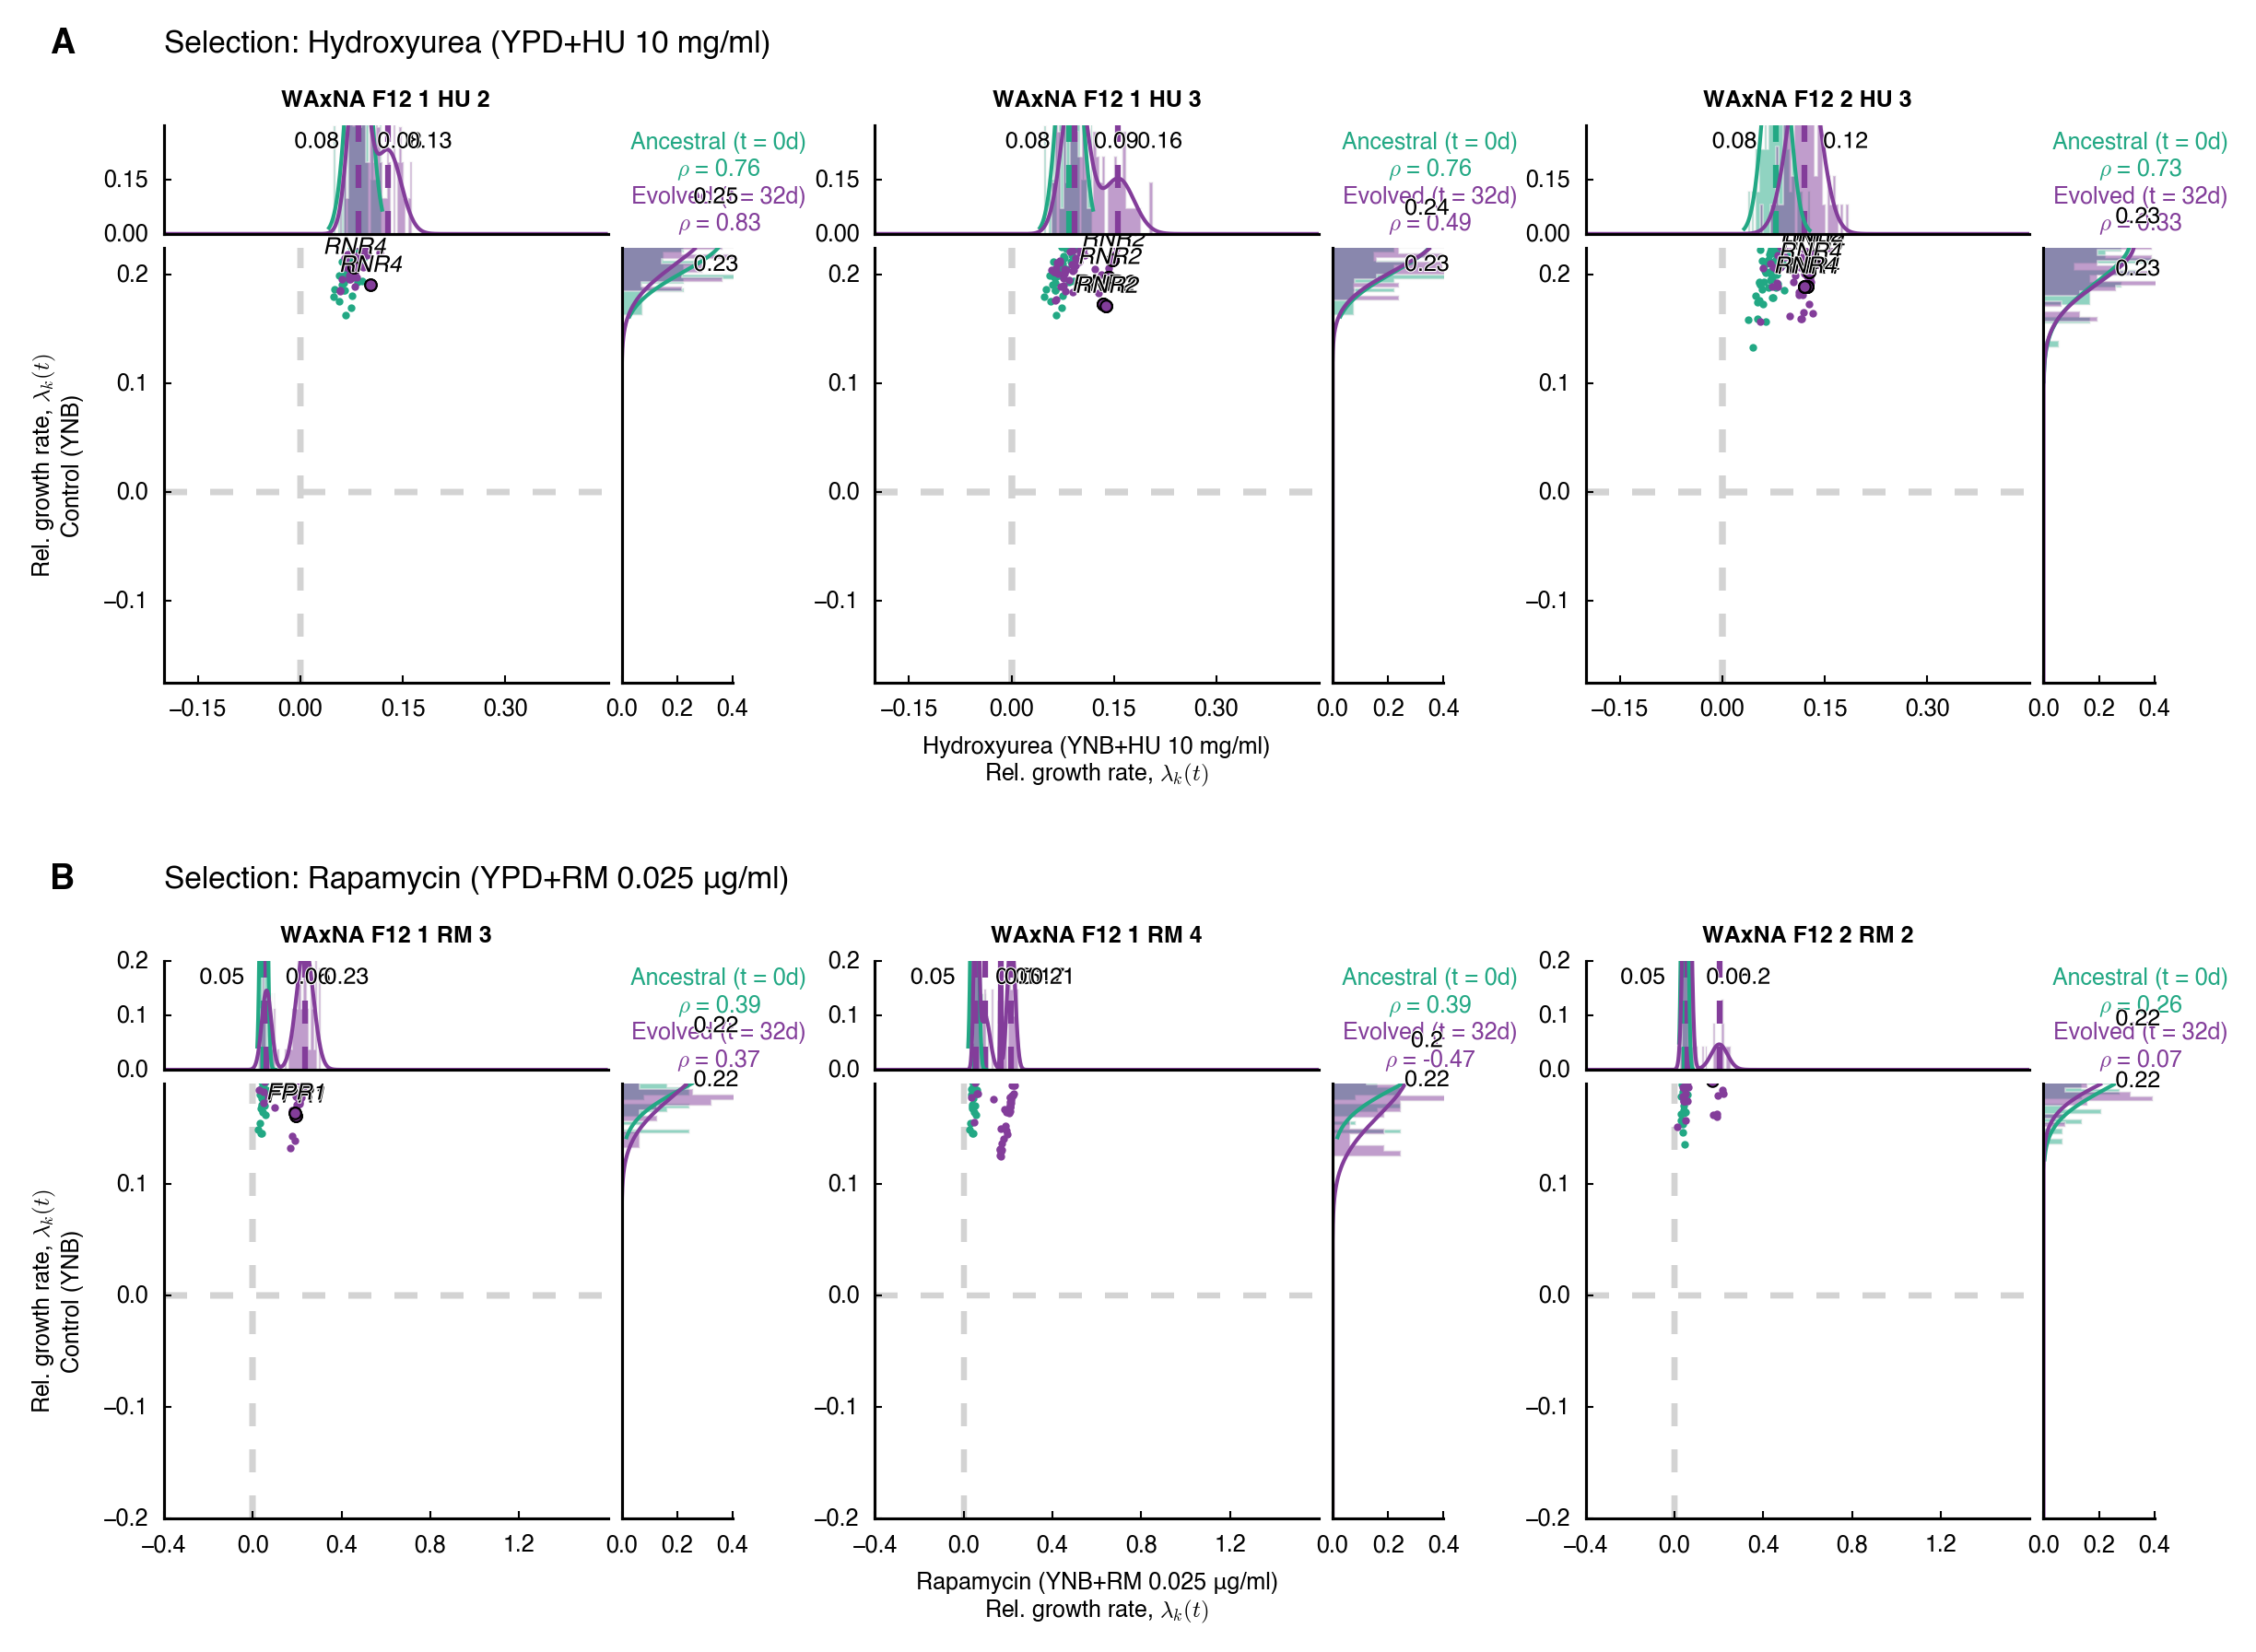

In [31]:
param='growth_rate'

scatter_panels = {
    'WAxNA_F12_1_HU_2':0,
    'WAxNA_F12_1_HU_3':1,
    'WAxNA_F12_2_HU_3':2,
    'WAxNA_F12_1_RM_3':3,
    'WAxNA_F12_1_RM_4':4,
    'WAxNA_F12_2_RM_2':5,
}

data = pheno_df[pheno_df.population.isin(scatter_panels.keys())]
data = pd.pivot_table(data, 
                      index=['selection','population','group','isolate','gene','genotype_long','assignment'], 
                      columns='environment', 
                      values=param)

corr = pheno_df[pheno_df.population.isin(scatter_panels.keys())]
corr = pd.pivot_table(corr, 
                      index=['isolate','gene','genotype_long','assignment'], 
                      columns=['selection','population','group','environment'], 
                      values=param)
corr = corr.groupby(level=['selection','population','group'], axis=1, group_keys=False).apply(lambda x: x.corr(method='spearman'))
corr = corr.query('environment==\'YNB\'')
corr = pd.melt(corr).dropna()
# corr['population'] = corr['population'].apply(lambda x: x.replace('_',' '))
corr = corr.pivot_table(columns=['group'], index=['selection','population','environment'], values='value')
    
    
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7.5,5.25))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98)

# make outer gridspec
grid = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[2, 2, 2], hspace=.5, wspace=.25) 

gs = {}

for ii, ((s, p), gp) in enumerate(data.groupby(level=['selection','population'])):
    print ii,s,p
    # gridspec enables you to assign different formats to panels in one plot.
    gs[(s,p)] = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, hspace=.05, wspace=.05, 
                                                 width_ratios=[4,1], height_ratios=[1,4], 
                                                 subplot_spec=grid[scatter_panels[p]])
    
    ax = plt.subplot(gs[(s,p)][:])
    ax_scatter = plt.subplot(gs[(s,p)][1,0])
    ax_x = plt.subplot(gs[(s,p)][0,0])
    ax_y = plt.subplot(gs[(s,p)][1,1])

    # Define plot ranges at beginning, since used often later
    x = gp['YNB'].values
    y = gp[s].values
    
    if s=='HU':
        x_range = [-0.2, 0.45]
        y_range = [-0.175, 0.225]
        x_count_range = [0, 0.4]
        y_count_range = [0, 0.3]
    elif s=='RM':
        x_range = [-0.4, 1.6]
        y_range = [-0.2, 0.19]
        x_count_range = [0, 0.4]
        y_count_range = [0, 0.2]

    # set title
    ax_x.set_title(p.replace('_',' '), fontsize=6, weight='bold')
    
    # Set title
    ax_scatter.annotate('Ancestral (t = 0d)\n' r'$\rho$ = {:.2f}'.format(corr.ix[s, p, s]['ancestral']),
                        xy=(1.25, 1.15), xycoords='axes fraction', fontsize=6,
                        color=config.population['color']['ancestral'], ha='center', va='bottom')
    ax_scatter.annotate('Evolved (t = 32d)\n' r'$\rho$ = {:.2f}'.format(corr.ix[s, p, s]['evolved']),
                        xy=(1.25, 1.025), xycoords='axes fraction', fontsize=6,
                        color=config.population['color']['evolved'], ha='center', va='bottom')

    for jj, (t, gt) in enumerate(gp.groupby(level='group')):
        
        gt_random = gt.query('gene==\'\'')#.groupby(level=['isolate','gene','genotype_long','assignment'])
        gt_target = gt.query('gene!=\'\'')
        
        x_a = gt[s]
        y_a = gt['YNB']
        
        x_r = gt_random[s]
        y_r = gt_random['YNB']
        color = config.population['color'][t]
        
        # scatter plot
        plot.scatter_plot(x_r, y_r, ax=ax_scatter, marker='.', color=color, ms=3)
        ax_scatter.set_xlim(x_range)
        ax_scatter.set_ylim(y_range)

#         ax_scatter.annotate(corr.ix[s, p, 'YNB'][t],
#                             xy=(0.95, 0.05), xycoords='axes fraction', fontsize=8,
#                             color=color, ha='right', va='bottom')
        
        for (environment, population, time, isolate, gene, genotype, z), data in gt_target.iterrows():
            x_t = gt_target[s]
            y_t = gt_target['YNB']
            plot.scatter_plot(x_t, y_t, ax=ax_scatter, marker='o', ms=3, mec='k', mfc=color)
            ax_scatter.annotate(gene,
                                xy = (data[s], data['YNB']), xycoords='data', 
                                xytext = (0, 8), textcoords = 'offset points', 
                                ha = 'center', va = 'top',
                                fontsize = 6, style = 'italic',
                                path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
        
        # x-axis
        plot.histogram_x(x_a, ax=ax_x, time=t)
        ax_x.set_xlim(x_range)
        ax_x.set_ylim(y_count_range)
        
        # mean of sequenced isolates       
#         lollipops(x_s, ax_x)
        
        # y-axis
        plot.histogram_y(y_a, ax=ax_y, time=t)
        ax_y.set_xlim(x_count_range)
        ax_y.set_ylim(y_range)

# Set axes labels
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_3')][1,0])
ax.set_xlabel('%s\nRel. growth rate, $\lambda_k(t)$' % config.environment['long_label']['HU'])
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_2')][1,0])
ax.set_ylabel('Rel. growth rate, $\lambda_k(t)$\n%s' % config.environment['long_label']['YNB'])

ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_4')][1,0])
ax.set_xlabel('%s\nRel. growth rate, $\lambda_k(t)$' % config.environment['long_label']['RM'])
ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_3')][1,0])
ax.set_ylabel('Rel. growth rate, $\lambda_k(t)$\n%s' % config.environment['long_label']['YNB'])

# Set panel labels
ax = plt.subplot(gs[('HU','WAxNA_F12_1_HU_2')][0,0])
ax.text(-.2, 1.75, chr(ord('A')), transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='center', ha='right')
ax.text(0, 1.75, 'Selection: %s' % config.selection['long_label']['HU'], transform=ax.transAxes,
        fontsize=8, va='center', ha='left')
ax = plt.subplot(gs[('RM','WAxNA_F12_1_RM_3')][0,0])
ax.text(-.2, 1.75, chr(ord('B')), transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='center', ha='right')
ax.text(0, 1.75, 'Selection: %s' % config.selection['long_label']['RM'], transform=ax.transAxes,
        fontsize=8, va='center', ha='left')
    
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=6)
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)

fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.pdf', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution_correlations.svg', bbox_inches='tight')
plt.show()